In [18]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline, splev, splrep
from scipy.optimize import minimize
from scipy.linalg import lstsq
from scipy.sparse import diags

# Define velocity limits
max_velocity = 2.0  # Maximum allowed velocity
min_velocity = -max_velocity  # Minimum allowed velocity

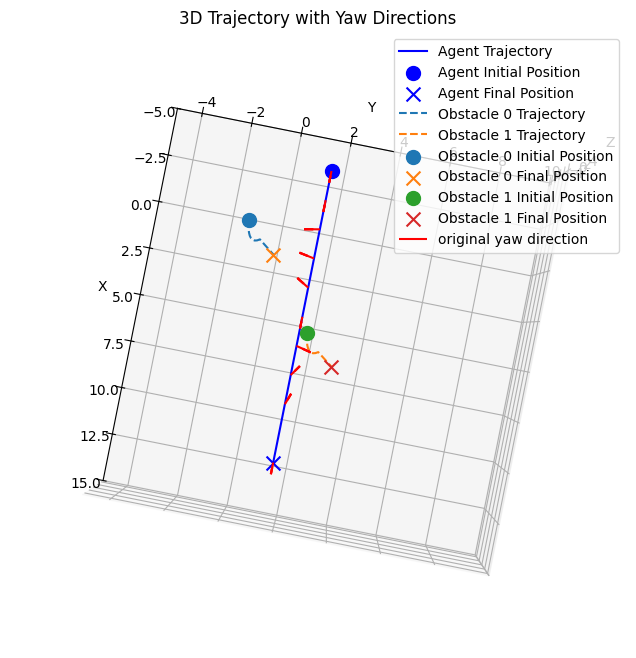

In [24]:
# Plot the trajectory
c = np.array([0.003431, 0.841424, -1.825243, -2.502847, 1.497153, 4.250505, 1.768529, 0.435196])  # Yaw values
t = np.array([0.000000, 0.000000, 0.000000, 0.000000, 2.000000, 4.000000, 6.000000, 8.000000, 10.000000, 10.000000, 10.000000, 10.000000])   # Knots
optimal_yaw_sequence = np.array([0.000000, 0.000000, -1.320146, -1.811382, -2.232935, 0.000000, 1.266964, 2.669556, 2.881309, 2.950777, 0.000000])
agent_trajectory = np.array([[-3.000000, 1.500000, 0.000000], [-1.500000, 1.500000, 0.000000], [0.000000, 1.500000, 0.000000], [1.500000, 1.500000, 0.000000], [3.000000, 1.500000, 0.000000], [4.500000, 1.500000, 0.000000], [6.000000, 1.500000, 0.000000], [7.500000, 1.500000, 0.000000], [9.000000, 1.500000, 0.000000], [10.500000, 1.500000, 0.000000], [12.000000, 1.500000, 0.000000]])
obstacle_trajectory_0 = np.array([[0.238403, -1.194005, 0.000000], [0.467302, -1.176080, 0.000000], [0.677571, -1.146404, 0.000000], [0.860827, -1.105273, 0.000000], [1.009765, -1.053099, 0.000000], [1.118447, -0.990403, 0.000000], [1.182540, -0.917811, 0.000000], [1.199488, -0.836048, 0.000000], [1.168617, -0.745932, 0.000000], [1.091157, -0.648363, 0.000000], [1.691157, -0.048363, -0.600000]])
obstacle_trajectory_1 = np.array([[5.238403, 1.805995, 0.000000], [5.467302, 1.823920, 0.000000], [5.677571, 1.853596, 0.000000], [5.860827, 1.894727, 0.000000], [6.009765, 1.946901, 0.000000], [6.118447, 2.009597, 0.000000], [6.182540, 2.082189, 0.000000], [6.199488, 2.163952, 0.000000], [6.168617, 2.254068, 0.000000], [6.091157, 2.351637, 0.000000], [6.691157, 2.951637, -0.600000]])

obstacles_trajectory = [obstacle_trajectory_0, obstacle_trajectory_1]

time_steps = np.arange(len(optimal_yaw_sequence))

# 3D Plot: Agent and Obstacles' Trajectories with Yaw Directions
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot agent trajectory
ax.plot(agent_trajectory[:, 0], agent_trajectory[:, 1], agent_trajectory[:, 2], label='Agent Trajectory', color='blue')

# Plot agent's initial and final positions as points
ax.scatter(agent_trajectory[0, 0], agent_trajectory[0, 1], agent_trajectory[0, 2], label='Agent Initial Position', color='blue', marker='o', s=100)
ax.scatter(agent_trajectory[-1, 0], agent_trajectory[-1, 1], agent_trajectory[-1, 2], label='Agent Final Position', color='blue', marker='x', s=100)

# Plot obstacles' trajectories
for i, obs_pos in enumerate(obstacles_trajectory):
    ax.plot(obs_pos[:, 0], obs_pos[:, 1], obs_pos[:, 2], label=f'Obstacle {i} Trajectory', linestyle='--')

# Plot obstacles' initial and final positions as points
for i, obs_pos in enumerate(obstacles_trajectory):
    ax.scatter(obs_pos[0, 0], obs_pos[0, 1], obs_pos[0, 2], label=f'Obstacle {i} Initial Position', marker='o', s=100)
    ax.scatter(obs_pos[-1, 0], obs_pos[-1, 1], obs_pos[-1, 2], label=f'Obstacle {i} Final Position', marker='x', s=100)

# Add yaw direction vectors at sampled time steps
sample_indices = np.linspace(0, len(time_steps) - 1, num=10, dtype=int)  # Adjust number of samples as needed
yaw_vectors = np.array([np.array([np.cos(optimal_yaw_sequence[i]), np.sin(optimal_yaw_sequence[i]), 0]) for i in sample_indices])

for idx, sample_idx in enumerate(sample_indices):
    pos = agent_trajectory[sample_idx]
    yaw_vector = yaw_vectors[idx]
    ax.quiver(pos[0], pos[1], pos[2], yaw_vector[0], yaw_vector[1], yaw_vector[2],
              length=0.6, color='red', arrow_length_ratio=0.6, label="original yaw direction" if idx == 0 else None)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Trajectory with Yaw Directions')
ax.legend()

# Set axis limits
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 10])
ax.set_zlim([-5, 5])

# Angle for rotating the plot
ax.view_init(elev=90, azim=10)

plt.show()

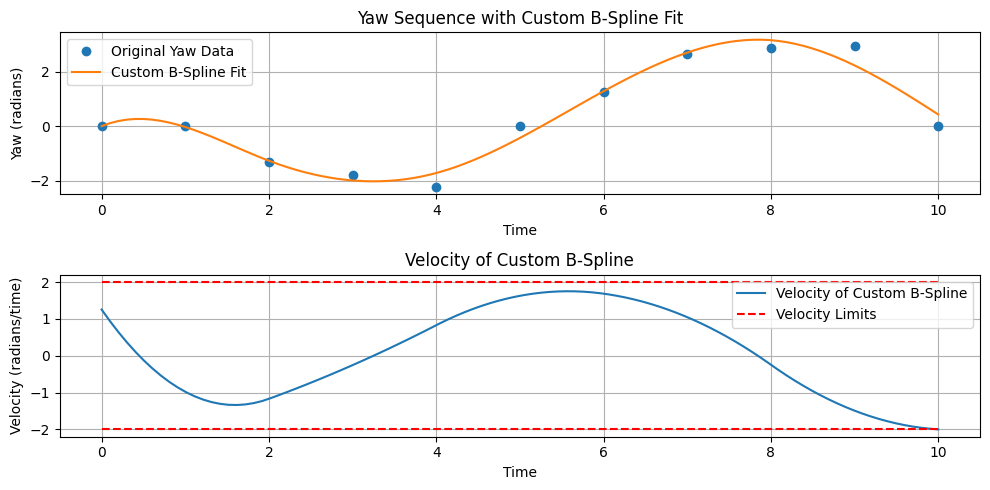

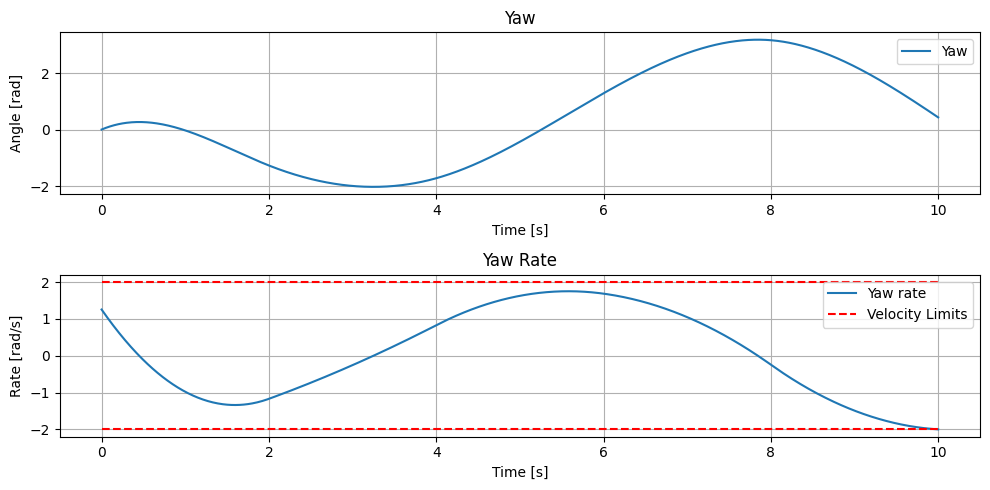

In [25]:
# Test fitting a B-spline to the yaw sequence
time_steps = np.linspace(0, 10, len(optimal_yaw_sequence))

k = 3  # Degree of the B-spline
spline = BSpline(t, c, k, extrapolate=False)
velocity_spline = spline.derivative(nu=1)

# Generate smooth values for plotting
time_smooth = np.linspace(time_steps.min(), time_steps.max(), 100)
yaw_smooth = splev(time_smooth, spline)
velocity_smooth = splev(time_smooth, velocity_spline)

# Plot original data, B-spline fit, and velocity
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(time_steps, optimal_yaw_sequence, 'o', label='Original Yaw Data')
plt.plot(time_smooth, yaw_smooth, '-', label='Custom B-Spline Fit')
plt.xlabel('Time')
plt.ylabel('Yaw (radians)')
plt.legend()
plt.grid()
plt.title('Yaw Sequence with Custom B-Spline Fit')

plt.subplot(2, 1, 2)
plt.plot(time_smooth, velocity_smooth, label='Velocity of Custom B-Spline')
plt.hlines([max_velocity, min_velocity], time_smooth.min(), time_smooth.max(), colors='r', linestyles='dashed', label='Velocity Limits')
plt.xlabel('Time')
plt.ylabel('Velocity (radians/time)')
plt.legend()
plt.grid()
plt.title('Velocity of Custom B-Spline')

plt.tight_layout()
plt.show()

# Path out put yaw (converted for the path_out in dynus.cpp)

path_out_yaw = np.array([0.003431, 0.015838, 0.027922, 0.039684, 0.051126, 0.062251, 0.073061, 0.083557, 0.093742, 0.103617, 0.113185, 0.122448, 0.131408, 0.140066, 0.148425, 0.156488, 0.164255, 0.171729, 0.178912, 0.185806, 0.192414, 0.198736, 0.204776, 0.210535, 0.216016, 0.221220, 0.226149, 0.230805, 0.235191, 0.239309, 0.243160, 0.246747, 0.250071, 0.253136, 0.255941, 0.258491, 0.260787, 0.262830, 0.264623, 0.266169, 0.267468, 0.268523, 0.269337, 0.269910, 0.270246, 0.270346, 0.270212, 0.269847, 0.269252, 0.268429, 0.267381, 0.266109, 0.264616, 0.262903, 0.260973, 0.258828, 0.256470, 0.253900, 0.251121, 0.248134, 0.244943, 0.241549, 0.237953, 0.234159, 0.230167, 0.225981, 0.221602, 0.217032, 0.212274, 0.207328, 0.202198, 0.196885, 0.191392, 0.185720, 0.179872, 0.173849, 0.167654, 0.161288, 0.154754, 0.148054, 0.141190, 0.134163, 0.126976, 0.119631, 0.112130, 0.104475, 0.096668, 0.088712, 0.080607, 0.072356, 0.063962, 0.055426, 0.046750, 0.037936, 0.028987, 0.019904, 0.010690, 0.001346, -0.008125, -0.017722, -0.027442, -0.037283, -0.047244, -0.057322, -0.067515, -0.077821, -0.088238, -0.098765, -0.109398, -0.120136, -0.130978, -0.141920, -0.152961, -0.164098, -0.175331, -0.186656, -0.198072, -0.209577, -0.221168, -0.232843, -0.244601, -0.256440, -0.268357, -0.280350, -0.292418, -0.304558, -0.316768, -0.329046, -0.341390, -0.353799, -0.366269, -0.378800, -0.391389, -0.404033, -0.416731, -0.429481, -0.442281, -0.455129, -0.468022, -0.480960, -0.493938, -0.506956, -0.520012, -0.533103, -0.546228, -0.559384, -0.572569, -0.585782, -0.599020, -0.612281, -0.625564, -0.638865, -0.652184, -0.665517, -0.678864, -0.692222, -0.705588, -0.718961, -0.732340, -0.745720, -0.759102, -0.772483, -0.785860, -0.799231, -0.812595, -0.825950, -0.839293, -0.852623, -0.865937, -0.879233, -0.892510, -0.905765, -0.918996, -0.932201, -0.945378, -0.958526, -0.971641, -0.984723, -0.997768, -1.010776, -1.023743, -1.036668, -1.049549, -1.062383, -1.075169, -1.087905, -1.100589, -1.113218, -1.125790, -1.138304, -1.150758, -1.163148, -1.175474, -1.187734, -1.199924, -1.212044, -1.224091, -1.236063, -1.247959, -1.259775, -1.271510, -1.283162, -1.294732, -1.306218, -1.317620, -1.328938, -1.340173, -1.351323, -1.362390, -1.373372, -1.384269, -1.395081, -1.405809, -1.416452, -1.427009, -1.437481, -1.447867, -1.458167, -1.468382, -1.478510, -1.488552, -1.498508, -1.508377, -1.518159, -1.527855, -1.537463, -1.546984, -1.556417, -1.565763, -1.575021, -1.584191, -1.593273, -1.602267, -1.611172, -1.619988, -1.628716, -1.637354, -1.645904, -1.654364, -1.662735, -1.671016, -1.679207, -1.687308, -1.695319, -1.703240, -1.711070, -1.718809, -1.726458, -1.734015, -1.741482, -1.748857, -1.756140, -1.763332, -1.770432, -1.777440, -1.784355, -1.791179, -1.797909, -1.804547, -1.811092, -1.817544, -1.823903, -1.830169, -1.836341, -1.842419, -1.848403, -1.854293, -1.860089, -1.865791, -1.871398, -1.876910, -1.882327, -1.887650, -1.892876, -1.898008, -1.903044, -1.907984, -1.912828, -1.917576, -1.922228, -1.926784, -1.931243, -1.935605, -1.939870, -1.944038, -1.948108, -1.952081, -1.955957, -1.959735, -1.963415, -1.966996, -1.970480, -1.973865, -1.977151, -1.980338, -1.983427, -1.986416, -1.989306, -1.992096, -1.994787, -1.997378, -1.999869, -2.002260, -2.004551, -2.006740, -2.008830, -2.010818, -2.012706, -2.014492, -2.016177, -2.017760, -2.019242, -2.020622, -2.021899, -2.023075, -2.024148, -2.025119, -2.025987, -2.026752, -2.027414, -2.027973, -2.028428, -2.028780, -2.029028, -2.029172, -2.029212, -2.029148, -2.028980, -2.028707, -2.028329, -2.027846, -2.027259, -2.026566, -2.025767, -2.024863, -2.023853, -2.022738, -2.021516, -2.020188, -2.018753, -2.017212, -2.015564, -2.013809, -2.011947, -2.009978, -2.007901, -2.005717, -2.003425, -2.001025, -1.998516, -1.995900, -1.993175, -1.990341, -1.987399, -1.984347, -1.981187, -1.977917, -1.974538, -1.971049, -1.967450, -1.963741, -1.959922, -1.955992, -1.951953, -1.947802, -1.943541, -1.939168, -1.934685, -1.930090, -1.925383, -1.920565, -1.915635, -1.910593, -1.905439, -1.900173, -1.894793, -1.889302, -1.883697, -1.877979, -1.872148, -1.866204, -1.860146, -1.853975, -1.847689, -1.841290, -1.834776, -1.828148, -1.821405, -1.814547, -1.807575, -1.800488, -1.793285, -1.785967, -1.778533, -1.770984, -1.763318, -1.755537, -1.747639, -1.739625, -1.731494, -1.723246, -1.714882, -1.706402, -1.697806, -1.689095, -1.680270, -1.671332, -1.662282, -1.653120, -1.643846, -1.634463, -1.624970, -1.615368, -1.605658, -1.595841, -1.585917, -1.575888, -1.565753, -1.555514, -1.545171, -1.534726, -1.524178, -1.513529, -1.502780, -1.491930, -1.480981, -1.469934, -1.458789, -1.447548, -1.436210, -1.424776, -1.413248, -1.401626, -1.389910, -1.378102, -1.366203, -1.354212, -1.342131, -1.329960, -1.317701, -1.305354, -1.292919, -1.280398, -1.267791, -1.255098, -1.242322, -1.229462, -1.216519, -1.203493, -1.190387, -1.177200, -1.163932, -1.150586, -1.137161, -1.123659, -1.110079, -1.096424, -1.082693, -1.068887, -1.055007, -1.041054, -1.027028, -1.012931, -0.998763, -0.984524, -0.970216, -0.955839, -0.941394, -0.926881, -0.912302, -0.897658, -0.882948, -0.868173, -0.853336, -0.838435, -0.823472, -0.808447, -0.793362, -0.778218, -0.763014, -0.747751, -0.732431, -0.717054, -0.701620, -0.686131, -0.670588, -0.654990, -0.639339, -0.623636, -0.607881, -0.592075, -0.576218, -0.560312, -0.544357, -0.528354, -0.512304, -0.496207, -0.480065, -0.463877, -0.447645, -0.431369, -0.415050, -0.398689, -0.382287, -0.365844, -0.349362, -0.332840, -0.316279, -0.299681, -0.283046, -0.266375, -0.249668, -0.232926, -0.216151, -0.199342, -0.182501, -0.165627, -0.148723, -0.131789, -0.114825, -0.097832, -0.080811, -0.063763, -0.046688, -0.029587, -0.012462, 0.004689, 0.021862, 0.039059, 0.056278, 0.073518, 0.090779, 0.108060, 0.125360, 0.142678, 0.160015, 0.177368, 0.194737, 0.212122, 0.229522, 0.246935, 0.264362, 0.281802, 0.299253, 0.316715, 0.334188, 0.351670, 0.369161, 0.386660, 0.404166, 0.421679, 0.439198, 0.456722, 0.474250, 0.491782, 0.509317, 0.526854, 0.544393, 0.561932, 0.579471, 0.597009, 0.614546, 0.632080, 0.649612, 0.667139, 0.684662, 0.702180, 0.719692, 0.737197, 0.754695, 0.772184, 0.789665, 0.807136, 0.824596, 0.842045, 0.859483, 0.876907, 0.894319, 0.911716, 0.929098, 0.946465, 0.963815, 0.981148, 0.998464, 1.015760, 1.033038, 1.050295, 1.067532, 1.084747, 1.101940, 1.119109, 1.136255, 1.153377, 1.170473, 1.187544, 1.204587, 1.221603, 1.238591, 1.255550, 1.272479, 1.289378, 1.306246, 1.323082, 1.339885, 1.356655, 1.373392, 1.390094, 1.406761, 1.423392, 1.439987, 1.456545, 1.473065, 1.489546, 1.505989, 1.522392, 1.538755, 1.555077, 1.571357, 1.587595, 1.603790, 1.619941, 1.636048, 1.652110, 1.668127, 1.684097, 1.700021, 1.715897, 1.731725, 1.747504, 1.763234, 1.778913, 1.794542, 1.810119, 1.825644, 1.841117, 1.856536, 1.871901, 1.887211, 1.902466, 1.917665, 1.932807, 1.947892, 1.962920, 1.977888, 1.992797, 2.007646, 2.022435, 2.037162, 2.051828, 2.066431, 2.080970, 2.095446, 2.109858, 2.124204, 2.138484, 2.152698, 2.166845, 2.180924, 2.194935, 2.208876, 2.222748, 2.236550, 2.250280, 2.263939, 2.277525, 2.291038, 2.304478, 2.317843, 2.331134, 2.344349, 2.357487, 2.370549, 2.383533, 2.396439, 2.409265, 2.422013, 2.434680, 2.447266, 2.459771, 2.472194, 2.484534, 2.496790, 2.508962, 2.521050, 2.533052, 2.544968, 2.556797, 2.568539, 2.580193, 2.591758, 2.603234, 2.614619, 2.625915, 2.637118, 2.648230, 2.659250, 2.670175, 2.681008, 2.691745, 2.702387, 2.712934, 2.723384, 2.733736, 2.743991, 2.754147, 2.764204, 2.774162, 2.784019, 2.793774, 2.803428, 2.812980, 2.822429, 2.831773, 2.841014, 2.850149, 2.859179, 2.868102, 2.876919, 2.885627, 2.894228, 2.902719, 2.911101, 2.919372, 2.927533, 2.935582, 2.943519, 2.951343, 2.959053, 2.966650, 2.974131, 2.981497, 2.988747, 2.995880, 3.002895, 3.009792, 3.016571, 3.023230, 3.029769, 3.036188, 3.042485, 3.048660, 3.054712, 3.060641, 3.066446, 3.072126, 3.077682, 3.083111, 3.088413, 3.093588, 3.098636, 3.103554, 3.108344, 3.113003, 3.117533, 3.121930, 3.126197, 3.130330, 3.134331, 3.138197, 3.141929, 3.145527, 3.148988, 3.152313, 3.155501, 3.158551, 3.161463, 3.164235, 3.166868, 3.169361, 3.171713, 3.173923, 3.175991, 3.177915, 3.179697, 3.181334, 3.182826, 3.184172, 3.185372, 3.186426, 3.187332, 3.188089, 3.188698, 3.189158, 3.189467, 3.189625, 3.189632, 3.189487, 3.189189, 3.188738, 3.188133, 3.187373, 3.186457, 3.185386, 3.184158, 3.182772, 3.181229, 3.179527, 3.177665, 3.175644, 3.173462, 3.171119, 3.168614, 3.165948, 3.163121, 3.160135, 3.156990, 3.153687, 3.150226, 3.146609, 3.142835, 3.138906, 3.134823, 3.130586, 3.126196, 3.121654, 3.116960, 3.112115, 3.107121, 3.101977, 3.096684, 3.091244, 3.085656, 3.079922, 3.074043, 3.068018, 3.061850, 3.055538, 3.049083, 3.042487, 3.035749, 3.028871, 3.021853, 3.014696, 3.007401, 2.999968, 2.992399, 2.984694, 2.976853, 2.968878, 2.960770, 2.952528, 2.944154, 2.935648, 2.927011, 2.918245, 2.909349, 2.900324, 2.891172, 2.881892, 2.872487, 2.862955, 2.853299, 2.843518, 2.833614, 2.823587, 2.813439, 2.803169, 2.792779, 2.782269, 2.771640, 2.760893, 2.750028, 2.739047, 2.727950, 2.716737, 2.705410, 2.693969, 2.682415, 2.670748, 2.658971, 2.647082, 2.635083, 2.622975, 2.610758, 2.598433, 2.586002, 2.573464, 2.560820, 2.548071, 2.535218, 2.522262, 2.509203, 2.496042, 2.482780, 2.469417, 2.455955, 2.442394, 2.428734, 2.414977, 2.401123, 2.387173, 2.373128, 2.358989, 2.344755, 2.330429, 2.316010, 2.301499, 2.286898, 2.272207, 2.257426, 2.242557, 2.227599, 2.212555, 2.197424, 2.182208, 2.166906, 2.151521, 2.136052, 2.120500, 2.104867, 2.089152, 2.073356, 2.057481, 2.041527, 2.025495, 2.009385, 1.993199, 1.976936, 1.960598, 1.944186, 1.927699, 1.911140, 1.894508, 1.877805, 1.861031, 1.844186, 1.827273, 1.810291, 1.793240, 1.776123, 1.758939, 1.741690, 1.724376, 1.706997, 1.689555, 1.672050, 1.654484, 1.636856, 1.619168, 1.601419, 1.583612, 1.565747, 1.547824, 1.529844, 1.511809, 1.493717, 1.475572, 1.457372, 1.439120, 1.420815, 1.402458, 1.384051, 1.365594, 1.347087, 1.328531, 1.309928, 1.291277, 1.272580, 1.253837, 1.235050, 1.216218, 1.197343, 1.178425, 1.159465, 1.140463, 1.121422, 1.102340, 1.083219, 1.064061, 1.044864, 1.025631, 1.006362, 0.987057, 0.967718, 0.948345, 0.928939, 0.909501, 0.890031, 0.870530, 0.850999, 0.831438, 0.811849, 0.792232, 0.772588, 0.752917, 0.733221, 0.713500, 0.693754, 0.673985, 0.654193, 0.634380, 0.614545, 0.594689, 0.574814, 0.554920, 0.535007, 0.515077, 0.495130, 0.475167, 0.455189, 0.435196])
path_out_dyaw = np.array([1.256990, 1.224522, 1.192259, 1.160200, 1.128346, 1.096695, 1.065250, 1.034008, 1.002971, 0.972138, 0.941510, 0.911086, 0.880867, 0.850852, 0.821041, 0.791434, 0.762032, 0.732835, 0.703841, 0.675053, 0.646468, 0.618088, 0.589912, 0.561941, 0.534174, 0.506611, 0.479253, 0.452099, 0.425150, 0.398405, 0.371864, 0.345528, 0.319396, 0.293468, 0.267745, 0.242226, 0.216912, 0.191802, 0.166896, 0.142195, 0.117698, 0.093405, 0.069317, 0.045433, 0.021754, -0.001721, -0.024992, -0.048058, -0.070920, -0.093577, -0.116031, -0.138279, -0.160324, -0.182164, -0.203799, -0.225230, -0.246457, -0.267480, -0.288298, -0.308912, -0.329321, -0.349526, -0.369526, -0.389323, -0.408914, -0.428302, -0.447485, -0.466464, -0.485238, -0.503808, -0.522173, -0.540334, -0.558291, -0.576044, -0.593592, -0.610935, -0.628074, -0.645009, -0.661740, -0.678266, -0.694588, -0.710705, -0.726618, -0.742327, -0.757831, -0.773131, -0.788226, -0.803117, -0.817804, -0.832286, -0.846564, -0.860638, -0.874507, -0.888172, -0.901632, -0.914888, -0.927940, -0.940787, -0.953430, -0.965869, -0.978103, -0.990133, -1.001958, -1.013579, -1.024996, -1.036208, -1.047216, -1.058019, -1.068618, -1.079013, -1.089203, -1.099189, -1.108971, -1.118548, -1.127921, -1.137089, -1.146053, -1.154813, -1.163368, -1.171719, -1.179866, -1.187808, -1.195546, -1.203079, -1.210408, -1.217533, -1.224453, -1.231169, -1.237681, -1.243988, -1.250091, -1.255989, -1.261683, -1.267173, -1.272458, -1.277539, -1.282415, -1.287087, -1.291555, -1.295818, -1.299877, -1.303732, -1.307382, -1.310828, -1.314070, -1.317107, -1.319939, -1.322568, -1.324992, -1.327211, -1.329226, -1.331037, -1.332643, -1.334045, -1.335243, -1.336236, -1.337025, -1.337610, -1.337990, -1.338166, -1.338137, -1.337904, -1.337467, -1.336825, -1.335979, -1.334928, -1.333673, -1.332214, -1.330550, -1.328682, -1.326610, -1.324333, -1.321852, -1.319167, -1.316277, -1.313182, -1.309884, -1.306381, -1.302673, -1.298761, -1.294645, -1.290324, -1.285799, -1.281070, -1.276136, -1.270998, -1.265656, -1.260109, -1.254358, -1.248402, -1.242242, -1.235878, -1.229309, -1.222536, -1.215558, -1.208376, -1.200990, -1.193399, -1.185604, -1.177605, -1.169401, -1.161087, -1.152755, -1.144407, -1.136042, -1.127659, -1.119260, -1.110844, -1.102411, -1.093961, -1.085494, -1.077010, -1.068510, -1.059992, -1.051457, -1.042906, -1.034337, -1.025751, -1.017149, -1.008530, -0.999893, -0.991240, -0.982570, -0.973883, -0.965179, -0.956458, -0.947720, -0.938965, -0.930193, -0.921404, -0.912598, -0.903776, -0.894936, -0.886080, -0.877206, -0.868316, -0.859408, -0.850484, -0.841543, -0.832585, -0.823609, -0.814617, -0.805608, -0.796582, -0.787540, -0.778480, -0.769403, -0.760309, -0.751199, -0.742071, -0.732927, -0.723765, -0.714587, -0.705391, -0.696179, -0.686950, -0.677704, -0.668441, -0.659161, -0.649864, -0.640550, -0.631219, -0.621871, -0.612506, -0.603125, -0.593726, -0.584310, -0.574878, -0.565428, -0.555962, -0.546479, -0.536978, -0.527461, -0.517927, -0.508376, -0.498808, -0.489223, -0.479621, -0.470002, -0.460366, -0.450714, -0.441044, -0.431357, -0.421654, -0.411933, -0.402196, -0.392442, -0.382670, -0.372882, -0.363077, -0.353255, -0.343416, -0.333560, -0.323687, -0.313797, -0.303890, -0.293966, -0.284025, -0.274068, -0.264093, -0.254102, -0.244093, -0.234068, -0.224025, -0.213966, -0.203890, -0.193797, -0.183687, -0.173560, -0.163416, -0.153255, -0.143077, -0.132882, -0.122670, -0.112442, -0.102196, -0.091933, -0.081654, -0.071357, -0.061044, -0.050714, -0.040366, -0.030002, -0.019621, -0.009223, 0.001192, 0.011624, 0.022073, 0.032539, 0.043022, 0.053521, 0.064038, 0.074572, 0.085122, 0.095690, 0.106274, 0.116875, 0.127494, 0.138129, 0.148781, 0.159450, 0.170136, 0.180839, 0.191559, 0.202296, 0.213050, 0.223821, 0.234609, 0.245413, 0.256235, 0.267073, 0.277929, 0.288801, 0.299691, 0.310597, 0.321520, 0.332460, 0.343418, 0.354392, 0.365383, 0.376391, 0.387415, 0.398457, 0.409516, 0.420592, 0.431684, 0.442794, 0.453920, 0.465064, 0.476224, 0.487402, 0.498596, 0.509807, 0.521035, 0.532280, 0.543542, 0.554821, 0.566117, 0.577430, 0.588760, 0.600107, 0.611470, 0.622851, 0.634249, 0.645663, 0.657094, 0.668543, 0.680008, 0.691490, 0.702990, 0.714506, 0.726039, 0.737589, 0.749156, 0.760740, 0.772341, 0.783958, 0.795593, 0.807245, 0.818913, 0.830599, 0.842256, 0.853839, 0.865348, 0.876782, 0.888143, 0.899430, 0.910643, 0.921781, 0.932846, 0.943836, 0.954753, 0.965595, 0.976364, 0.987058, 0.997678, 1.008224, 1.018696, 1.029094, 1.039418, 1.049668, 1.059844, 1.069946, 1.079974, 1.089928, 1.099808, 1.109613, 1.119345, 1.129002, 1.138586, 1.148095, 1.157531, 1.166892, 1.176179, 1.185393, 1.194532, 1.203597, 1.212588, 1.221505, 1.230348, 1.239117, 1.247812, 1.256432, 1.264979, 1.273452, 1.281851, 1.290175, 1.298426, 1.306602, 1.314705, 1.322733, 1.330687, 1.338568, 1.346374, 1.354106, 1.361764, 1.369348, 1.376858, 1.384294, 1.391656, 1.398944, 1.406158, 1.413297, 1.420363, 1.427355, 1.434272, 1.441116, 1.447885, 1.454581, 1.461202, 1.467749, 1.474223, 1.480622, 1.486947, 1.493198, 1.499375, 1.505478, 1.511507, 1.517462, 1.523343, 1.529150, 1.534882, 1.540541, 1.546126, 1.551636, 1.557073, 1.562435, 1.567724, 1.572938, 1.578078, 1.583145, 1.588137, 1.593055, 1.597899, 1.602669, 1.607365, 1.611987, 1.616535, 1.621009, 1.625408, 1.629734, 1.633986, 1.638163, 1.642267, 1.646297, 1.650252, 1.654133, 1.657941, 1.661674, 1.665333, 1.668919, 1.672430, 1.675867, 1.679230, 1.682519, 1.685734, 1.688875, 1.691941, 1.694934, 1.697853, 1.700697, 1.703468, 1.706165, 1.708787, 1.711336, 1.713810, 1.716210, 1.718537, 1.720789, 1.722967, 1.725071, 1.727101, 1.729057, 1.730939, 1.732747, 1.734481, 1.736141, 1.737727, 1.739238, 1.740676, 1.742039, 1.743329, 1.744545, 1.745686, 1.746753, 1.747747, 1.748666, 1.749511, 1.750282, 1.750979, 1.751603, 1.752152, 1.752627, 1.753027, 1.753354, 1.753607, 1.753786, 1.753890, 1.753921, 1.753878, 1.753760, 1.753569, 1.753303, 1.752964, 1.752550, 1.752062, 1.751500, 1.750864, 1.750155, 1.749371, 1.748513, 1.747581, 1.746574, 1.745494, 1.744340, 1.743112, 1.741810, 1.740433, 1.738983, 1.737458, 1.735860, 1.734187, 1.732441, 1.730620, 1.728725, 1.726756, 1.724713, 1.722597, 1.720406, 1.718141, 1.715802, 1.713388, 1.710901, 1.708340, 1.705705, 1.702995, 1.700212, 1.697355, 1.694423, 1.691418, 1.688338, 1.685189, 1.681974, 1.678694, 1.675349, 1.671938, 1.668462, 1.664920, 1.661313, 1.657641, 1.653903, 1.650100, 1.646232, 1.642298, 1.638299, 1.634234, 1.630105, 1.625909, 1.621649, 1.617323, 1.612931, 1.608475, 1.603953, 1.599365, 1.594712, 1.589994, 1.585210, 1.580362, 1.575447, 1.570468, 1.565422, 1.560312, 1.555136, 1.549895, 1.544589, 1.539217, 1.533779, 1.528277, 1.522709, 1.517075, 1.511376, 1.505612, 1.499783, 1.493888, 1.487928, 1.481902, 1.475811, 1.469655, 1.463433, 1.457146, 1.450793, 1.444376, 1.437892, 1.431344, 1.424730, 1.418050, 1.411306, 1.404496, 1.397620, 1.390679, 1.383673, 1.376602, 1.369465, 1.362262, 1.354995, 1.347662, 1.340263, 1.332800, 1.325270, 1.317676, 1.310016, 1.302291, 1.294500, 1.286644, 1.278723, 1.270736, 1.262684, 1.254566, 1.246383, 1.238135, 1.229822, 1.221443, 1.212998, 1.204489, 1.195914, 1.187273, 1.178567, 1.169796, 1.160959, 1.152058, 1.143090, 1.134058, 1.124959, 1.115796, 1.106567, 1.097273, 1.087914, 1.078489, 1.068998, 1.059443, 1.049822, 1.040135, 1.030384, 1.020566, 1.010684, 1.000736, 0.990723, 0.980644, 0.970500, 0.960291, 0.950016, 0.939676, 0.929271, 0.918800, 0.908264, 0.897662, 0.886995, 0.876263, 0.865465, 0.854602, 0.843673, 0.832680, 0.821620, 0.810496, 0.799306, 0.788051, 0.776730, 0.765344, 0.753893, 0.742376, 0.730794, 0.719146, 0.707433, 0.695655, 0.683811, 0.671902, 0.659928, 0.647888, 0.635783, 0.623613, 0.611377, 0.599076, 0.586709, 0.574277, 0.561780, 0.549217, 0.536589, 0.523896, 0.511137, 0.498313, 0.485423, 0.472468, 0.459448, 0.446362, 0.433211, 0.419995, 0.406713, 0.393366, 0.379953, 0.366475, 0.352932, 0.339323, 0.325649, 0.311910, 0.298105, 0.284235, 0.270300, 0.256299, 0.242232, 0.228101, 0.213904, 0.199642, 0.185314, 0.170921, 0.156462, 0.141938, 0.127349, 0.112695, 0.097975, 0.083189, 0.068339, 0.053423, 0.038441, 0.023394, 0.008282, -0.006895, -0.022138, -0.037446, -0.052820, -0.068259, -0.083764, -0.099333, -0.114968, -0.130669, -0.146435, -0.162266, -0.178163, -0.194125, -0.210152, -0.226245, -0.242403, -0.258557, -0.274636, -0.290642, -0.306574, -0.322431, -0.338215, -0.353925, -0.369560, -0.385122, -0.400609, -0.416023, -0.431362, -0.446628, -0.461819, -0.476937, -0.491980, -0.506949, -0.521845, -0.536666, -0.551413, -0.566086, -0.580685, -0.595211, -0.609662, -0.624039, -0.638342, -0.652571, -0.666726, -0.680807, -0.694814, -0.708747, -0.722606, -0.736391, -0.750102, -0.763738, -0.777301, -0.790790, -0.804205, -0.817545, -0.830812, -0.844005, -0.857123, -0.870168, -0.883138, -0.896035, -0.908858, -0.921606, -0.934280, -0.946881, -0.959407, -0.971860, -0.984238, -0.996542, -1.008773, -1.020929, -1.033011, -1.045019, -1.056953, -1.068814, -1.080600, -1.092312, -1.103950, -1.115514, -1.127004, -1.138420, -1.149762, -1.161030, -1.172224, -1.183344, -1.194389, -1.205361, -1.216259, -1.227083, -1.237832, -1.248508, -1.259110, -1.269638, -1.280091, -1.290471, -1.300776, -1.311008, -1.321165, -1.331249, -1.341258, -1.351194, -1.361055, -1.370842, -1.380556, -1.390195, -1.399760, -1.409252, -1.418669, -1.428012, -1.437281, -1.446476, -1.455597, -1.464645, -1.473618, -1.482517, -1.491342, -1.500093, -1.508770, -1.517372, -1.525901, -1.534356, -1.542737, -1.551044, -1.559277, -1.567435, -1.575520, -1.583531, -1.591467, -1.599330, -1.607119, -1.614833, -1.622474, -1.630040, -1.637533, -1.644951, -1.652296, -1.659566, -1.666762, -1.673885, -1.680933, -1.687907, -1.694808, -1.701634, -1.708386, -1.715064, -1.721669, -1.728199, -1.734655, -1.741037, -1.747345, -1.753579, -1.759739, -1.765825, -1.771837, -1.777775, -1.783639, -1.789428, -1.795144, -1.800786, -1.806354, -1.811848, -1.817267, -1.822613, -1.827885, -1.833082, -1.838206, -1.843255, -1.848231, -1.853132, -1.857960, -1.862713, -1.867393, -1.871998, -1.876530, -1.880987, -1.885370, -1.889680, -1.893915, -1.898076, -1.902163, -1.906176, -1.910116, -1.913981, -1.917772, -1.921489, -1.925132, -1.928701, -1.932196, -1.935617, -1.938964, -1.942237, -1.945436, -1.948560, -1.951611, -1.954588, -1.957491, -1.960319, -1.963074, -1.965755, -1.968361, -1.970894, -1.973353, -1.975737, -1.978048, -1.980284, -1.982447, -1.984535, -1.986550, -1.988490, -1.990356, -1.992149, -1.993867, -1.995511, -1.997082, -1.998578, -2.000000])
t = np.array([0.000000, 0.010000, 0.020000, 0.030000, 0.040000, 0.050000, 0.060000, 0.070000, 0.080000, 0.090000, 0.100000, 0.110000, 0.120000, 0.130000, 0.140000, 0.150000, 0.160000, 0.170000, 0.180000, 0.190000, 0.200000, 0.210000, 0.220000, 0.230000, 0.240000, 0.250000, 0.260000, 0.270000, 0.280000, 0.290000, 0.300000, 0.310000, 0.320000, 0.330000, 0.340000, 0.350000, 0.360000, 0.370000, 0.380000, 0.390000, 0.400000, 0.410000, 0.420000, 0.430000, 0.440000, 0.450000, 0.460000, 0.470000, 0.480000, 0.490000, 0.500000, 0.510000, 0.520000, 0.530000, 0.540000, 0.550000, 0.560000, 0.570000, 0.580000, 0.590000, 0.600000, 0.610000, 0.620000, 0.630000, 0.640000, 0.650000, 0.660000, 0.670000, 0.680000, 0.690000, 0.700000, 0.710000, 0.720000, 0.730000, 0.740000, 0.750000, 0.760000, 0.770000, 0.780000, 0.790000, 0.800000, 0.810000, 0.820000, 0.830000, 0.840000, 0.850000, 0.860000, 0.870000, 0.880000, 0.890000, 0.900000, 0.910000, 0.920000, 0.930000, 0.940000, 0.950000, 0.960000, 0.970000, 0.980000, 0.990000, 1.000000, 1.010000, 1.020000, 1.030000, 1.040000, 1.050000, 1.060000, 1.070000, 1.080000, 1.090000, 1.100000, 1.110000, 1.120000, 1.130000, 1.140000, 1.150000, 1.160000, 1.170000, 1.180000, 1.190000, 1.200000, 1.210000, 1.220000, 1.230000, 1.240000, 1.250000, 1.260000, 1.270000, 1.280000, 1.290000, 1.300000, 1.310000, 1.320000, 1.330000, 1.340000, 1.350000, 1.360000, 1.370000, 1.380000, 1.390000, 1.400000, 1.410000, 1.420000, 1.430000, 1.440000, 1.450000, 1.460000, 1.470000, 1.480000, 1.490000, 1.500000, 1.510000, 1.520000, 1.530000, 1.540000, 1.550000, 1.560000, 1.570000, 1.580000, 1.590000, 1.600000, 1.610000, 1.620000, 1.630000, 1.640000, 1.650000, 1.660000, 1.670000, 1.680000, 1.690000, 1.700000, 1.710000, 1.720000, 1.730000, 1.740000, 1.750000, 1.760000, 1.770000, 1.780000, 1.790000, 1.800000, 1.810000, 1.820000, 1.830000, 1.840000, 1.850000, 1.860000, 1.870000, 1.880000, 1.890000, 1.900000, 1.910000, 1.920000, 1.930000, 1.940000, 1.950000, 1.960000, 1.970000, 1.980000, 1.990000, 2.000000, 2.010000, 2.020000, 2.030000, 2.040000, 2.050000, 2.060000, 2.070000, 2.080000, 2.090000, 2.100000, 2.110000, 2.120000, 2.130000, 2.140000, 2.150000, 2.160000, 2.170000, 2.180000, 2.190000, 2.200000, 2.210000, 2.220000, 2.230000, 2.240000, 2.250000, 2.260000, 2.270000, 2.280000, 2.290000, 2.300000, 2.310000, 2.320000, 2.330000, 2.340000, 2.350000, 2.360000, 2.370000, 2.380000, 2.390000, 2.400000, 2.410000, 2.420000, 2.430000, 2.440000, 2.450000, 2.460000, 2.470000, 2.480000, 2.490000, 2.500000, 2.510000, 2.520000, 2.530000, 2.540000, 2.550000, 2.560000, 2.570000, 2.580000, 2.590000, 2.600000, 2.610000, 2.620000, 2.630000, 2.640000, 2.650000, 2.660000, 2.670000, 2.680000, 2.690000, 2.700000, 2.710000, 2.720000, 2.730000, 2.740000, 2.750000, 2.760000, 2.770000, 2.780000, 2.790000, 2.800000, 2.810000, 2.820000, 2.830000, 2.840000, 2.850000, 2.860000, 2.870000, 2.880000, 2.890000, 2.900000, 2.910000, 2.920000, 2.930000, 2.940000, 2.950000, 2.960000, 2.970000, 2.980000, 2.990000, 3.000000, 3.010000, 3.020000, 3.030000, 3.040000, 3.050000, 3.060000, 3.070000, 3.080000, 3.090000, 3.100000, 3.110000, 3.120000, 3.130000, 3.140000, 3.150000, 3.160000, 3.170000, 3.180000, 3.190000, 3.200000, 3.210000, 3.220000, 3.230000, 3.240000, 3.250000, 3.260000, 3.270000, 3.280000, 3.290000, 3.300000, 3.310000, 3.320000, 3.330000, 3.340000, 3.350000, 3.360000, 3.370000, 3.380000, 3.390000, 3.400000, 3.410000, 3.420000, 3.430000, 3.440000, 3.450000, 3.460000, 3.470000, 3.480000, 3.490000, 3.500000, 3.510000, 3.520000, 3.530000, 3.540000, 3.550000, 3.560000, 3.570000, 3.580000, 3.590000, 3.600000, 3.610000, 3.620000, 3.630000, 3.640000, 3.650000, 3.660000, 3.670000, 3.680000, 3.690000, 3.700000, 3.710000, 3.720000, 3.730000, 3.740000, 3.750000, 3.760000, 3.770000, 3.780000, 3.790000, 3.800000, 3.810000, 3.820000, 3.830000, 3.840000, 3.850000, 3.860000, 3.870000, 3.880000, 3.890000, 3.900000, 3.910000, 3.920000, 3.930000, 3.940000, 3.950000, 3.960000, 3.970000, 3.980000, 3.990000, 4.000000, 4.010000, 4.020000, 4.030000, 4.040000, 4.050000, 4.060000, 4.070000, 4.080000, 4.090000, 4.100000, 4.110000, 4.120000, 4.130000, 4.140000, 4.150000, 4.160000, 4.170000, 4.180000, 4.190000, 4.200000, 4.210000, 4.220000, 4.230000, 4.240000, 4.250000, 4.260000, 4.270000, 4.280000, 4.290000, 4.300000, 4.310000, 4.320000, 4.330000, 4.340000, 4.350000, 4.360000, 4.370000, 4.380000, 4.390000, 4.400000, 4.410000, 4.420000, 4.430000, 4.440000, 4.450000, 4.460000, 4.470000, 4.480000, 4.490000, 4.500000, 4.510000, 4.520000, 4.530000, 4.540000, 4.550000, 4.560000, 4.570000, 4.580000, 4.590000, 4.600000, 4.610000, 4.620000, 4.630000, 4.640000, 4.650000, 4.660000, 4.670000, 4.680000, 4.690000, 4.700000, 4.710000, 4.720000, 4.730000, 4.740000, 4.750000, 4.760000, 4.770000, 4.780000, 4.790000, 4.800000, 4.810000, 4.820000, 4.830000, 4.840000, 4.850000, 4.860000, 4.870000, 4.880000, 4.890000, 4.900000, 4.910000, 4.920000, 4.930000, 4.940000, 4.950000, 4.960000, 4.970000, 4.980000, 4.990000, 5.000000, 5.010000, 5.020000, 5.030000, 5.040000, 5.050000, 5.060000, 5.070000, 5.080000, 5.090000, 5.100000, 5.110000, 5.120000, 5.130000, 5.140000, 5.150000, 5.160000, 5.170000, 5.180000, 5.190000, 5.200000, 5.210000, 5.220000, 5.230000, 5.240000, 5.250000, 5.260000, 5.270000, 5.280000, 5.290000, 5.300000, 5.310000, 5.320000, 5.330000, 5.340000, 5.350000, 5.360000, 5.370000, 5.380000, 5.390000, 5.400000, 5.410000, 5.420000, 5.430000, 5.440000, 5.450000, 5.460000, 5.470000, 5.480000, 5.490000, 5.500000, 5.510000, 5.520000, 5.530000, 5.540000, 5.550000, 5.560000, 5.570000, 5.580000, 5.590000, 5.600000, 5.610000, 5.620000, 5.630000, 5.640000, 5.650000, 5.660000, 5.670000, 5.680000, 5.690000, 5.700000, 5.710000, 5.720000, 5.730000, 5.740000, 5.750000, 5.760000, 5.770000, 5.780000, 5.790000, 5.800000, 5.810000, 5.820000, 5.830000, 5.840000, 5.850000, 5.860000, 5.870000, 5.880000, 5.890000, 5.900000, 5.910000, 5.920000, 5.930000, 5.940000, 5.950000, 5.960000, 5.970000, 5.980000, 5.990000, 6.000000, 6.010000, 6.020000, 6.030000, 6.040000, 6.050000, 6.060000, 6.070000, 6.080000, 6.090000, 6.100000, 6.110000, 6.120000, 6.130000, 6.140000, 6.150000, 6.160000, 6.170000, 6.180000, 6.190000, 6.200000, 6.210000, 6.220000, 6.230000, 6.240000, 6.250000, 6.260000, 6.270000, 6.280000, 6.290000, 6.300000, 6.310000, 6.320000, 6.330000, 6.340000, 6.350000, 6.360000, 6.370000, 6.380000, 6.390000, 6.400000, 6.410000, 6.420000, 6.430000, 6.440000, 6.450000, 6.460000, 6.470000, 6.480000, 6.490000, 6.500000, 6.510000, 6.520000, 6.530000, 6.540000, 6.550000, 6.560000, 6.570000, 6.580000, 6.590000, 6.600000, 6.610000, 6.620000, 6.630000, 6.640000, 6.650000, 6.660000, 6.670000, 6.680000, 6.690000, 6.700000, 6.710000, 6.720000, 6.730000, 6.740000, 6.750000, 6.760000, 6.770000, 6.780000, 6.790000, 6.800000, 6.810000, 6.820000, 6.830000, 6.840000, 6.850000, 6.860000, 6.870000, 6.880000, 6.890000, 6.900000, 6.910000, 6.920000, 6.930000, 6.940000, 6.950000, 6.960000, 6.970000, 6.980000, 6.990000, 7.000000, 7.010000, 7.020000, 7.030000, 7.040000, 7.050000, 7.060000, 7.070000, 7.080000, 7.090000, 7.100000, 7.110000, 7.120000, 7.130000, 7.140000, 7.150000, 7.160000, 7.170000, 7.180000, 7.190000, 7.200000, 7.210000, 7.220000, 7.230000, 7.240000, 7.250000, 7.260000, 7.270000, 7.280000, 7.290000, 7.300000, 7.310000, 7.320000, 7.330000, 7.340000, 7.350000, 7.360000, 7.370000, 7.380000, 7.390000, 7.400000, 7.410000, 7.420000, 7.430000, 7.440000, 7.450000, 7.460000, 7.470000, 7.480000, 7.490000, 7.500000, 7.510000, 7.520000, 7.530000, 7.540000, 7.550000, 7.560000, 7.570000, 7.580000, 7.590000, 7.600000, 7.610000, 7.620000, 7.630000, 7.640000, 7.650000, 7.660000, 7.670000, 7.680000, 7.690000, 7.700000, 7.710000, 7.720000, 7.730000, 7.740000, 7.750000, 7.760000, 7.770000, 7.780000, 7.790000, 7.800000, 7.810000, 7.820000, 7.830000, 7.840000, 7.850000, 7.860000, 7.870000, 7.880000, 7.890000, 7.900000, 7.910000, 7.920000, 7.930000, 7.940000, 7.950000, 7.960000, 7.970000, 7.980000, 7.990000, 8.000000, 8.010000, 8.020000, 8.030000, 8.040000, 8.050000, 8.060000, 8.070000, 8.080000, 8.090000, 8.100000, 8.110000, 8.120000, 8.130000, 8.140000, 8.150000, 8.160000, 8.170000, 8.180000, 8.190000, 8.200000, 8.210000, 8.220000, 8.230000, 8.240000, 8.250000, 8.260000, 8.270000, 8.280000, 8.290000, 8.300000, 8.310000, 8.320000, 8.330000, 8.340000, 8.350000, 8.360000, 8.370000, 8.380000, 8.390000, 8.400000, 8.410000, 8.420000, 8.430000, 8.440000, 8.450000, 8.460000, 8.470000, 8.480000, 8.490000, 8.500000, 8.510000, 8.520000, 8.530000, 8.540000, 8.550000, 8.560000, 8.570000, 8.580000, 8.590000, 8.600000, 8.610000, 8.620000, 8.630000, 8.640000, 8.650000, 8.660000, 8.670000, 8.680000, 8.690000, 8.700000, 8.710000, 8.720000, 8.730000, 8.740000, 8.750000, 8.760000, 8.770000, 8.780000, 8.790000, 8.800000, 8.810000, 8.820000, 8.830000, 8.840000, 8.850000, 8.860000, 8.870000, 8.880000, 8.890000, 8.900000, 8.910000, 8.920000, 8.930000, 8.940000, 8.950000, 8.960000, 8.970000, 8.980000, 8.990000, 9.000000, 9.010000, 9.020000, 9.030000, 9.040000, 9.050000, 9.060000, 9.070000, 9.080000, 9.090000, 9.100000, 9.110000, 9.120000, 9.130000, 9.140000, 9.150000, 9.160000, 9.170000, 9.180000, 9.190000, 9.200000, 9.210000, 9.220000, 9.230000, 9.240000, 9.250000, 9.260000, 9.270000, 9.280000, 9.290000, 9.300000, 9.310000, 9.320000, 9.330000, 9.340000, 9.350000, 9.360000, 9.370000, 9.380000, 9.390000, 9.400000, 9.410000, 9.420000, 9.430000, 9.440000, 9.450000, 9.460000, 9.470000, 9.480000, 9.490000, 9.500000, 9.510000, 9.520000, 9.530000, 9.540000, 9.550000, 9.560000, 9.570000, 9.580000, 9.590000, 9.600000, 9.610000, 9.620000, 9.630000, 9.640000, 9.650000, 9.660000, 9.670000, 9.680000, 9.690000, 9.700000, 9.710000, 9.720000, 9.730000, 9.740000, 9.750000, 9.760000, 9.770000, 9.780000, 9.790000, 9.800000, 9.810000, 9.820000, 9.830000, 9.840000, 9.850000, 9.860000, 9.870000, 9.880000, 9.890000, 9.900000, 9.910000, 9.920000, 9.930000, 9.940000, 9.950000, 9.960000, 9.970000, 9.980000, 9.990000, 10.000000])

time_smooth = np.linspace(t.min(), t.max(), 100)

# Plot the data
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(t, path_out_yaw, label='Yaw')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.title('Yaw')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, path_out_dyaw, label='Yaw rate')
plt.hlines([max_velocity, min_velocity], time_smooth.min(), time_smooth.max(), colors='r', linestyles='dashed', label='Velocity Limits')
plt.xlabel('Time [s]')
plt.ylabel('Rate [rad/s]')
plt.title('Yaw Rate')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

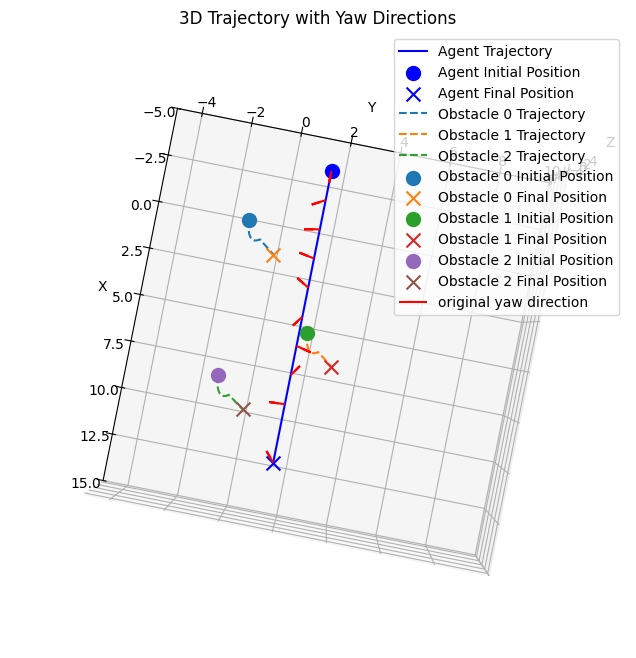

In [8]:
# Plot the trajectory for 3 obstacles

optimal_yaw_sequence = np.array([0, -0.936872, -1.32015, -1.81138, -2.23293, -0.494537, 1.26696, 2.66956, -1.49586, -2.15122, -2.55086])
agent_trajectory = np.array([[-3, 1.5, 0], [-1.5, 1.5, 0], [0, 1.5, 0], [1.5, 1.5, 0], [3, 1.5, 0], [4.5, 1.5, 0], [6, 1.5, 0], [7.5, 1.5, 0], [9, 1.5, 0], [10.5, 1.5, 0], [12, 1.5, 0]])
obstacle_trajectory_0 = np.array([[0.238403, -1.194, 0], [0.467302, -1.17608, 0], [0.677571, -1.1464, 0], [0.860827, -1.10527, 0], [1.00977, -1.0531, 0], [1.11845, -0.990403, 0], [1.18254, -0.917811, 0], [1.19949, -0.836048, 0], [1.16862, -0.745932, 0], [1.09116, -0.648363, 0], [1.69116, -0.0483628, -0.6]])
obstacle_trajectory_1 = np.array([[5.2384, 1.806, 0], [5.4673, 1.82392, 0], [5.67757, 1.8536, 0], [5.86083, 1.89473, 0], [6.00977, 1.9469, 0], [6.11845, 2.0096, 0], [6.18254, 2.08219, 0], [6.19949, 2.16395, 0], [6.16862, 2.25407, 0], [6.09116, 2.35164, 0], [6.69116, 2.95164, -0.6]])
obstacle_trajectory_2 = np.array([[8.2384, -1.194, 0], [8.4673, -1.17608, 0], [8.67757, -1.1464, 0], [8.86083, -1.10527, 0], [9.00977, -1.0531, 0], [9.11845, -0.990403, 0], [9.18254, -0.917811, 0], [9.19949, -0.836048, 0], [9.16862, -0.745932, 0], [9.09116, -0.648363, 0], [9.69116, -0.0483628, -0.6]])

obstacles_trajectory = [obstacle_trajectory_0, obstacle_trajectory_1, obstacle_trajectory_2]

time_steps = np.arange(len(optimal_yaw_sequence))

# 3D Plot: Agent and Obstacles' Trajectories with Yaw Directions
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot agent trajectory
ax.plot(agent_trajectory[:, 0], agent_trajectory[:, 1], agent_trajectory[:, 2], label='Agent Trajectory', color='blue')

# Plot agent's initial and final positions as points
ax.scatter(agent_trajectory[0, 0], agent_trajectory[0, 1], agent_trajectory[0, 2], label='Agent Initial Position', color='blue', marker='o', s=100)
ax.scatter(agent_trajectory[-1, 0], agent_trajectory[-1, 1], agent_trajectory[-1, 2], label='Agent Final Position', color='blue', marker='x', s=100)

# Plot obstacles' trajectories
for i, obs_pos in enumerate(obstacles_trajectory):
    ax.plot(obs_pos[:, 0], obs_pos[:, 1], obs_pos[:, 2], label=f'Obstacle {i} Trajectory', linestyle='--')

# Plot obstacles' initial and final positions as points
for i, obs_pos in enumerate(obstacles_trajectory):
    ax.scatter(obs_pos[0, 0], obs_pos[0, 1], obs_pos[0, 2], label=f'Obstacle {i} Initial Position', marker='o', s=100)
    ax.scatter(obs_pos[-1, 0], obs_pos[-1, 1], obs_pos[-1, 2], label=f'Obstacle {i} Final Position', marker='x', s=100)

# Add yaw direction vectors at sampled time steps
sample_indices = np.linspace(0, len(time_steps) - 1, num=10, dtype=int)  # Adjust number of samples as needed
yaw_vectors = np.array([np.array([np.cos(optimal_yaw_sequence[i]), np.sin(optimal_yaw_sequence[i]), 0]) for i in sample_indices])

for idx, sample_idx in enumerate(sample_indices):
    pos = agent_trajectory[sample_idx]
    yaw_vector = yaw_vectors[idx]
    ax.quiver(pos[0], pos[1], pos[2], yaw_vector[0], yaw_vector[1], yaw_vector[2],
              length=0.6, color='red', arrow_length_ratio=0.6, label="original yaw direction" if idx == 0 else None)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Trajectory with Yaw Directions')
ax.legend()

# Set axis limits
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 10])
ax.set_zlim([-5, 5])

# Angle for rotating the plot
ax.view_init(elev=90, azim=10)

plt.show()

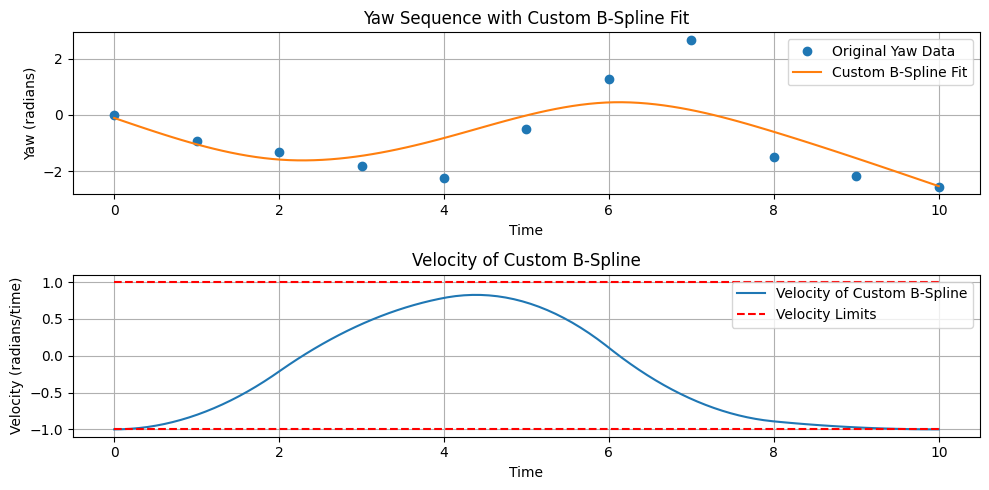

In [9]:
# Test fitting a B-spline to the yaw sequence
c = np.array([-0.106291, -0.772957, -2.106291, -0.960845, 1.039155, -0.526254, -1.859588, -2.526254])  # Yaw values
t = np.array([0.000000, 0.000000, 0.000000, 0.000000, 2.000000, 4.000000, 6.000000, 8.000000, 10.000000, 10.000000, 10.000000, 10.000000])   # Knots
time_steps = np.linspace(0, 10, len(optimal_yaw_sequence))

# Define velocity limits
max_velocity = 1.0  # Maximum allowed velocity
min_velocity = -1.0  # Minimum allowed velocity

k = 3  # Degree of the B-spline
spline = BSpline(t, c, k, extrapolate=False)
velocity_spline = spline.derivative(nu=1)

# Generate smooth values for plotting
time_smooth = np.linspace(time_steps.min(), time_steps.max(), 100)
yaw_smooth = splev(time_smooth, spline)
velocity_smooth = splev(time_smooth, velocity_spline)

# Plot original data, B-spline fit, and velocity
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(time_steps, optimal_yaw_sequence, 'o', label='Original Yaw Data')
plt.plot(time_smooth, yaw_smooth, '-', label='Custom B-Spline Fit')
plt.xlabel('Time')
plt.ylabel('Yaw (radians)')
plt.legend()
plt.grid()
plt.title('Yaw Sequence with Custom B-Spline Fit')

plt.subplot(2, 1, 2)
plt.plot(time_smooth, velocity_smooth, label='Velocity of Custom B-Spline')
plt.hlines([max_velocity, min_velocity], time_smooth.min(), time_smooth.max(), colors='r', linestyles='dashed', label='Velocity Limits')
plt.xlabel('Time')
plt.ylabel('Velocity (radians/time)')
plt.legend()
plt.grid()
plt.title('Velocity of Custom B-Spline')

plt.tight_layout()
plt.show()

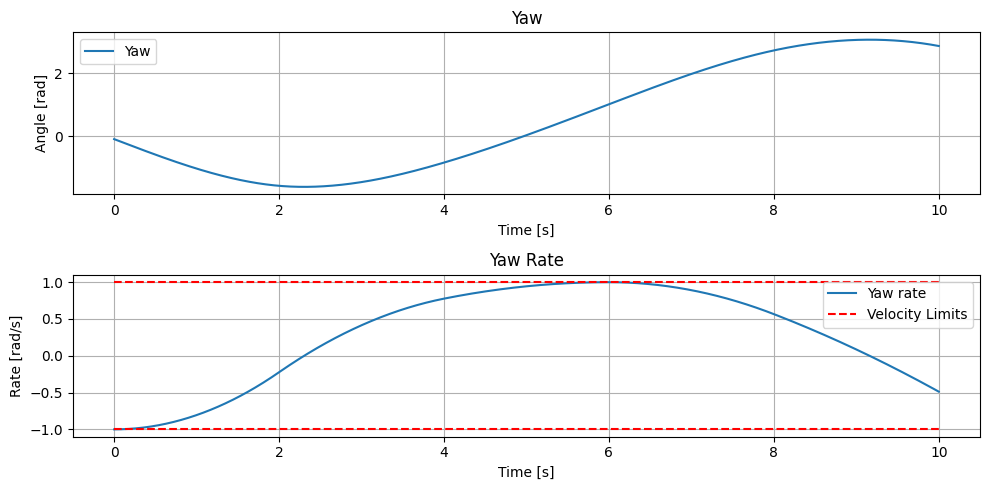

In [10]:
# Plot path out from BsplineFitting for 2 obstacles
path_out_yaw = np.array([-0.0955237, -0.105524, -0.115523, -0.125522, -0.13552, -0.145516, -0.15551, -0.165501, -0.175491, -0.185476, -0.195459, -0.205438, -0.215412, -0.225381, -0.235346, -0.245305, -0.255259, -0.265206, -0.275146, -0.28508, -0.295006, -0.304924, -0.314835, -0.324736, -0.334629, -0.344513, -0.354386, -0.36425, -0.374103, -0.383946, -0.393777, -0.403596, -0.413403, -0.423198, -0.43298, -0.442749, -0.452505, -0.462246, -0.471973, -0.481685, -0.491383, -0.501064, -0.51073, -0.520379, -0.530012, -0.539627, -0.549226, -0.558806, -0.568368, -0.577911, -0.587436, -0.596941, -0.606426, -0.615891, -0.625335, -0.634758, -0.644161, -0.653541, -0.662899, -0.672235, -0.681548, -0.690837, -0.700103, -0.709345, -0.718562, -0.727754, -0.736921, -0.746063, -0.755179, -0.764268, -0.77333, -0.782365, -0.791373, -0.800353, -0.809304, -0.818227, -0.82712, -0.835984, -0.844818, -0.853622, -0.862395, -0.871137, -0.879848, -0.888527, -0.897173, -0.905787, -0.914368, -0.922916, -0.93143, -0.939909, -0.948354, -0.956765, -0.965139, -0.973479, -0.981782, -0.990048, -0.998278, -1.00647, -1.01462, -1.02274, -1.03082, -1.03886, -1.04686, -1.05482, -1.06274, -1.07062, -1.07846, -1.08626, -1.09402, -1.10173, -1.1094, -1.11703, -1.12462, -1.13216, -1.13966, -1.14712, -1.15453, -1.16189, -1.16921, -1.17649, -1.18372, -1.1909, -1.19803, -1.20512, -1.21216, -1.21915, -1.22609, -1.23299, -1.23983, -1.24662, -1.25337, -1.26006, -1.26671, -1.2733, -1.27984, -1.28633, -1.29276, -1.29915, -1.30548, -1.31175, -1.31798, -1.32414, -1.33026, -1.33632, -1.34232, -1.34827, -1.35416, -1.35999, -1.36577, -1.37149, -1.37715, -1.38275, -1.3883, -1.39378, -1.39921, -1.40457, -1.40988, -1.41513, -1.42031, -1.42544, -1.4305, -1.4355, -1.44043, -1.44531, -1.45012, -1.45487, -1.45955, -1.46417, -1.46872, -1.47321, -1.47763, -1.48199, -1.48628, -1.49051, -1.49466, -1.49875, -1.50277, -1.50673, -1.51061, -1.51443, -1.51817, -1.52185, -1.52545, -1.52899, -1.53245, -1.53584, -1.53916, -1.54241, -1.54559, -1.54869, -1.55172, -1.55468, -1.55756, -1.56036, -1.5631, -1.56575, -1.56833, -1.57084, -1.57327, -1.57562, -1.57789, -1.58009, -1.58221, -1.58425, -1.58622, -1.58811, -1.58992, -1.59166, -1.59332, -1.5949, -1.59641, -1.59785, -1.59921, -1.6005, -1.60171, -1.60285, -1.60391, -1.6049, -1.60582, -1.60667, -1.60744, -1.60815, -1.60878, -1.60933, -1.60982, -1.61024, -1.61058, -1.61086, -1.61106, -1.6112, -1.61126, -1.61126, -1.61119, -1.61104, -1.61083, -1.61056, -1.61021, -1.60979, -1.60931, -1.60876, -1.60815, -1.60747, -1.60672, -1.6059, -1.60502, -1.60408, -1.60307, -1.60199, -1.60085, -1.59964, -1.59837, -1.59704, -1.59564, -1.59418, -1.59266, -1.59108, -1.58943, -1.58772, -1.58595, -1.58411, -1.58222, -1.58026, -1.57825, -1.57617, -1.57403, -1.57183, -1.56958, -1.56726, -1.56488, -1.56245, -1.55996, -1.5574, -1.5548, -1.55213, -1.5494, -1.54662, -1.54378, -1.54089, -1.53794, -1.53493, -1.53186, -1.52875, -1.52557, -1.52234, -1.51906, -1.51572, -1.51233, -1.50888, -1.50538, -1.50183, -1.49822, -1.49456, -1.49085, -1.48709, -1.48327, -1.4794, -1.47548, -1.47151, -1.46749, -1.46342, -1.4593, -1.45513, -1.45091, -1.44664, -1.44232, -1.43795, -1.43353, -1.42906, -1.42455, -1.41999, -1.41538, -1.41072, -1.40602, -1.40127, -1.39647, -1.39163, -1.38674, -1.38181, -1.37683, -1.3718, -1.36673, -1.36162, -1.35646, -1.35126, -1.34602, -1.34073, -1.3354, -1.33002, -1.3246, -1.31914, -1.31364, -1.3081, -1.30252, -1.29689, -1.29122, -1.28552, -1.27977, -1.27398, -1.26815, -1.26229, -1.25638, -1.25044, -1.24445, -1.23843, -1.23237, -1.22627, -1.22014, -1.21396, -1.20775, -1.20151, -1.19522, -1.18891, -1.18255, -1.17616, -1.16973, -1.16327, -1.15678, -1.15025, -1.14368, -1.13708, -1.13045, -1.12378, -1.11709, -1.11035, -1.10359, -1.09679, -1.08996, -1.0831, -1.07621, -1.06929, -1.06234, -1.05535, -1.04834, -1.04129, -1.03422, -1.02711, -1.01998, -1.01281, -1.00562, -0.998403, -0.991155, -0.983879, -0.976576, -0.969245, -0.961887, -0.954502, -0.947091, -0.939653, -0.93219, -0.924701, -0.917186, -0.909647, -0.902082, -0.894493, -0.88688, -0.879243, -0.871582, -0.863897, -0.856189, -0.848459, -0.840706, -0.83293, -0.825132, -0.817312, -0.80947, -0.801606, -0.793721, -0.785813, -0.777884, -0.769934, -0.761962, -0.753969, -0.745955, -0.73792, -0.729864, -0.721787, -0.713689, -0.705571, -0.697433, -0.689274, -0.681095, -0.672895, -0.664676, -0.656437, -0.648178, -0.639899, -0.631601, -0.623284, -0.614947, -0.60659, -0.598215, -0.589821, -0.581408, -0.572976, -0.564525, -0.556056, -0.547568, -0.539062, -0.530538, -0.521996, -0.513435, -0.504857, -0.496261, -0.487648, -0.479017, -0.470368, -0.461702, -0.453019, -0.444319, -0.435601, -0.426867, -0.418116, -0.409349, -0.400565, -0.391764, -0.382948, -0.374115, -0.365265, -0.3564, -0.347519, -0.338623, -0.32971, -0.320782, -0.311839, -0.30288, -0.293906, -0.284917, -0.275914, -0.266895, -0.257861, -0.248813, -0.23975, -0.230673, -0.221582, -0.212476, -0.203356, -0.194223, -0.185075, -0.175914, -0.166739, -0.15755, -0.148348, -0.139133, -0.129905, -0.120663, -0.111409, -0.102142, -0.0928616, -0.0835689, -0.0742637, -0.0649462, -0.0556163, -0.0462742, -0.0369201, -0.027554, -0.0181761, -0.00878639, 0.000614912, 0.0100277, 0.0194519, 0.0288874, 0.0383341, 0.0477919, 0.0572606, 0.0667401, 0.0762304, 0.0857313, 0.0952427, 0.104765, 0.114297, 0.123839, 0.133391, 0.142953, 0.152526, 0.162107, 0.171699, 0.1813, 0.19091, 0.20053, 0.210158, 0.219796, 0.229443, 0.239099, 0.248763, 0.258436, 0.268117, 0.277807, 0.287505, 0.297211, 0.306926, 0.316648, 0.326378, 0.336116, 0.345861, 0.355614, 0.365374, 0.375142, 0.384916, 0.394698, 0.404486, 0.414282, 0.424084, 0.433893, 0.443708, 0.45353, 0.463357, 0.473191, 0.483031, 0.492877, 0.502729, 0.512587, 0.52245, 0.532318, 0.542192, 0.552071, 0.561956, 0.571845, 0.581739, 0.591638, 0.601542, 0.61145, 0.621363, 0.63128, 0.641202, 0.651127, 0.661057, 0.67099, 0.680927, 0.690868, 0.700813, 0.710761, 0.720712, 0.730667, 0.740625, 0.750585, 0.760549, 0.770515, 0.780485, 0.790456, 0.80043, 0.810407, 0.820386, 0.830367, 0.840349, 0.850334, 0.860321, 0.870309, 0.880299, 0.89029, 0.900283, 0.910277, 0.920271, 0.930267, 0.940264, 0.950262, 0.96026, 0.970259, 0.980258, 0.990258, 1.00026, 1.01026, 1.02026, 1.03026, 1.04026, 1.05026, 1.06025, 1.07025, 1.08025, 1.09024, 1.10023, 1.11022, 1.12021, 1.1302, 1.14018, 1.15016, 1.16014, 1.17011, 1.18008, 1.19005, 1.20001, 1.20997, 1.21992, 1.22987, 1.23982, 1.24976, 1.25969, 1.26962, 1.27955, 1.28946, 1.29938, 1.30928, 1.31918, 1.32907, 1.33896, 1.34884, 1.35871, 1.36857, 1.37843, 1.38827, 1.39811, 1.40794, 1.41777, 1.42758, 1.43738, 1.44718, 1.45696, 1.46674, 1.4765, 1.48626, 1.496, 1.50574, 1.51546, 1.52517, 1.53488, 1.54457, 1.55424, 1.56391, 1.57356, 1.5832, 1.59283, 1.60245, 1.61205, 1.62164, 1.63122, 1.64078, 1.65033, 1.65986, 1.66938, 1.67889, 1.68838, 1.69786, 1.70732, 1.71676, 1.72619, 1.73561, 1.74501, 1.75439, 1.76375, 1.7731, 1.78243, 1.79175, 1.80105, 1.81033, 1.81959, 1.82883, 1.83806, 1.84726, 1.85645, 1.86562, 1.87477, 1.8839, 1.89302, 1.90211, 1.91118, 1.92023, 1.92926, 1.93827, 1.94726, 1.95623, 1.96518, 1.97411, 1.98301, 1.99189, 2.00075, 2.00959, 2.01841, 2.0272, 2.03597, 2.04472, 2.05344, 2.06214, 2.07082, 2.07947, 2.0881, 2.0967, 2.10528, 2.11383, 2.12236, 2.13086, 2.13934, 2.14779, 2.15621, 2.16461, 2.17299, 2.18133, 2.18965, 2.19794, 2.20621, 2.21444, 2.22265, 2.23083, 2.23899, 2.24711, 2.25521, 2.26327, 2.27131, 2.27932, 2.2873, 2.29525, 2.30317, 2.31106, 2.31892, 2.32675, 2.33454, 2.34231, 2.35005, 2.35775, 2.36542, 2.37306, 2.38067, 2.38825, 2.39579, 2.4033, 2.41078, 2.41822, 2.42564, 2.43301, 2.44036, 2.44767, 2.45494, 2.46218, 2.46939, 2.47656, 2.4837, 2.4908, 2.49786, 2.50489, 2.51188, 2.51884, 2.52576, 2.53265, 2.53949, 2.5463, 2.55308, 2.55981, 2.56651, 2.57317, 2.57979, 2.58637, 2.59292, 2.59942, 2.60589, 2.61232, 2.61871, 2.62505, 2.63136, 2.63763, 2.64386, 2.65004, 2.65619, 2.6623, 2.66836, 2.67438, 2.68036, 2.6863, 2.6922, 2.69806, 2.70387, 2.70964, 2.71536, 2.72105, 2.72669, 2.73228, 2.73784, 2.74335, 2.74881, 2.75423, 2.75961, 2.76495, 2.77024, 2.77548, 2.78068, 2.78584, 2.79095, 2.79602, 2.80104, 2.80602, 2.81095, 2.81584, 2.82069, 2.82548, 2.83024, 2.83494, 2.83961, 2.84422, 2.84879, 2.85332, 2.8578, 2.86223, 2.86662, 2.87096, 2.87526, 2.87951, 2.88371, 2.88787, 2.89198, 2.89604, 2.90006, 2.90403, 2.90795, 2.91182, 2.91565, 2.91943, 2.92317, 2.92685, 2.93049, 2.93408, 2.93763, 2.94113, 2.94457, 2.94797, 2.95133, 2.95463, 2.95789, 2.96109, 2.96425, 2.96736, 2.97043, 2.97344, 2.97641, 2.97932, 2.98219, 2.98501, 2.98777, 2.99049, 2.99316, 2.99578, 2.99836, 3.00088, 3.00335, 3.00577, 3.00814, 3.01047, 3.01274, 3.01496, 3.01713, 3.01925, 3.02132, 3.02334, 3.02531, 3.02723, 3.0291, 3.03092, 3.03268, 3.0344, 3.03606, 3.03767, 3.03924, 3.04075, 3.0422, 3.04361, 3.04496, 3.04627, 3.04752, 3.04872, 3.04986, 3.05096, 3.052, 3.05299, 3.05393, 3.05481, 3.05564, 3.05642, 3.05715, 3.05782, 3.05844, 3.05901, 3.05952, 3.05998, 3.06039, 3.06074, 3.06104, 3.06129, 3.06148, 3.06162, 3.06171, 3.06174, 3.06171, 3.06164, 3.0615, 3.06132, 3.06107, 3.06078, 3.06043, 3.06002, 3.05956, 3.05905, 3.05848, 3.05785, 3.05717, 3.05643, 3.05564, 3.05479, 3.05389, 3.05293, 3.05192, 3.05084, 3.04972, 3.04853, 3.0473, 3.046, 3.04465, 3.04324, 3.04177, 3.04025, 3.03867, 3.03704, 3.03535, 3.0336, 3.03179, 3.02993, 3.028, 3.02603, 3.02399, 3.0219, 3.01974, 3.01754, 3.01527, 3.01294, 3.01056, 3.00812, 3.00562, 3.00306, 3.00044, 2.99777, 2.99504, 2.99224, 2.98939, 2.98648, 2.98351, 2.98048, 2.9774, 2.97425, 2.97104, 2.96778, 2.96445, 2.96107, 2.95762, 2.95412, 2.95055, 2.94693, 2.94324, 2.9395, 2.93569, 2.93183, 2.9279, 2.92391, 2.91987, 2.91576, 2.91159, 2.90736, 2.90307, 2.89871, 2.8943, 2.88983, 2.88529, 2.88069, 2.87603, 2.87131, 2.86653, 2.86168])
path_out_dyaw = np.array([-1, -0.99998, -0.999922, -0.999825, -0.999689, -0.999514, -0.999301, -0.999049, -0.998757, -0.998427, -0.998059, -0.997651, -0.997205, -0.996719, -0.996195, -0.995632, -0.995031, -0.99439, -0.993711, -0.992992, -0.992235, -0.991439, -0.990605, -0.989731, -0.988819, -0.987868, -0.986878, -0.985849, -0.984781, -0.983675, -0.98253, -0.981346, -0.980123, -0.978861, -0.977561, -0.976221, -0.974843, -0.973426, -0.97197, -0.970475, -0.968942, -0.96737, -0.965759, -0.964109, -0.96242, -0.960692, -0.958926, -0.957121, -0.955277, -0.953394, -0.951472, -0.949511, -0.947512, -0.945474, -0.943397, -0.941281, -0.939127, -0.936933, -0.934701, -0.93243, -0.93012, -0.927771, -0.925383, -0.922957, -0.920492, -0.917988, -0.915445, -0.912863, -0.910243, -0.907583, -0.904885, -0.902148, -0.899373, -0.896558, -0.893705, -0.890812, -0.887881, -0.884911, -0.881903, -0.878855, -0.875769, -0.872643, -0.869479, -0.866277, -0.863035, -0.859754, -0.856435, -0.853077, -0.84968, -0.846244, -0.84277, -0.839256, -0.835704, -0.832113, -0.828483, -0.824814, -0.821107, -0.817361, -0.813575, -0.809751, -0.805889, -0.801987, -0.798047, -0.794067, -0.790049, -0.785992, -0.781896, -0.777762, -0.773588, -0.769376, -0.765125, -0.760835, -0.756507, -0.752139, -0.747733, -0.743288, -0.738804, -0.734281, -0.729719, -0.725119, -0.72048, -0.715802, -0.711085, -0.706329, -0.701534, -0.696701, -0.691829, -0.686918, -0.681968, -0.676979, -0.671952, -0.666886, -0.66178, -0.656636, -0.651454, -0.646232, -0.640972, -0.635672, -0.630334, -0.624957, -0.619542, -0.614087, -0.608594, -0.603062, -0.597491, -0.591881, -0.586232, -0.580545, -0.574819, -0.569053, -0.563249, -0.557407, -0.551525, -0.545605, -0.539646, -0.533647, -0.527611, -0.521535, -0.51542, -0.509267, -0.503075, -0.496844, -0.490574, -0.484266, -0.477918, -0.471532, -0.465107, -0.458643, -0.45214, -0.445599, -0.439018, -0.432399, -0.425741, -0.419044, -0.412309, -0.405534, -0.398721, -0.391869, -0.384978, -0.378048, -0.371079, -0.364072, -0.357026, -0.349941, -0.342817, -0.335654, -0.328452, -0.321212, -0.313933, -0.306615, -0.299258, -0.291862, -0.284428, -0.276955, -0.269443, -0.261892, -0.254302, -0.246673, -0.239006, -0.2313, -0.223555, -0.215804, -0.208081, -0.200386, -0.192718, -0.185078, -0.177466, -0.169881, -0.162324, -0.154794, -0.147292, -0.139818, -0.132372, -0.124953, -0.117561, -0.110198, -0.102862, -0.0955536, -0.0882729, -0.0810199, -0.0737945, -0.0665967, -0.0594266, -0.0522842, -0.0451694, -0.0380822, -0.0310227, -0.0239908, -0.0169866, -0.01001, -0.00306108, 0.00386021, 0.0107539, 0.0176199, 0.0244582, 0.0312689, 0.038052, 0.0448074, 0.0515352, 0.0582354, 0.0649079, 0.0715527, 0.0781699, 0.0847595, 0.0913214, 0.0978557, 0.104362, 0.110841, 0.117293, 0.123716, 0.130112, 0.136481, 0.142822, 0.149135, 0.15542, 0.161678, 0.167908, 0.174111, 0.180286, 0.186433, 0.192552, 0.198644, 0.204709, 0.210745, 0.216754, 0.222736, 0.228689, 0.234616, 0.240514, 0.246385, 0.252228, 0.258043, 0.263831, 0.269592, 0.275324, 0.281029, 0.286706, 0.292356, 0.297978, 0.303572, 0.309139, 0.314678, 0.32019, 0.325673, 0.33113, 0.336558, 0.341959, 0.347332, 0.352678, 0.357996, 0.363286, 0.368548, 0.373783, 0.378991, 0.38417, 0.389322, 0.394447, 0.399544, 0.404613, 0.409654, 0.414668, 0.419654, 0.424613, 0.429544, 0.434447, 0.439322, 0.44417, 0.448991, 0.453783, 0.458548, 0.463286, 0.467996, 0.472678, 0.477332, 0.481959, 0.486558, 0.49113, 0.495673, 0.50019, 0.504678, 0.509139, 0.513572, 0.517978, 0.522356, 0.526706, 0.531029, 0.535324, 0.539592, 0.543831, 0.548043, 0.552228, 0.556385, 0.560514, 0.564616, 0.568689, 0.572736, 0.576754, 0.580745, 0.584709, 0.588644, 0.592552, 0.596433, 0.600286, 0.604111, 0.607908, 0.611678, 0.61542, 0.619135, 0.622822, 0.626481, 0.630112, 0.633716, 0.637293, 0.640841, 0.644362, 0.647856, 0.651321, 0.654759, 0.65817, 0.661553, 0.664908, 0.668235, 0.671535, 0.674807, 0.678052, 0.681269, 0.684458, 0.68762, 0.690754, 0.69386, 0.696939, 0.69999, 0.703013, 0.706009, 0.708977, 0.711918, 0.714831, 0.717716, 0.720573, 0.723403, 0.726206, 0.72898, 0.731727, 0.734446, 0.737138, 0.739802, 0.742439, 0.745047, 0.747628, 0.750182, 0.752708, 0.755206, 0.757676, 0.760119, 0.762534, 0.764922, 0.767282, 0.769614, 0.771919, 0.774196, 0.776445, 0.778675, 0.780894, 0.783102, 0.785298, 0.787483, 0.789657, 0.79182, 0.793972, 0.796113, 0.798242, 0.80036, 0.802467, 0.804563, 0.806648, 0.808721, 0.810783, 0.812834, 0.814874, 0.816903, 0.818921, 0.820927, 0.822922, 0.824906, 0.826879, 0.828841, 0.830791, 0.832731, 0.834659, 0.836576, 0.838482, 0.840376, 0.84226, 0.844132, 0.845993, 0.847843, 0.849682, 0.851509, 0.853326, 0.855131, 0.856925, 0.858708, 0.86048, 0.86224, 0.863989, 0.865727, 0.867454, 0.86917, 0.870875, 0.872568, 0.874251, 0.875922, 0.877581, 0.87923, 0.880868, 0.882494, 0.884109, 0.885713, 0.887306, 0.888888, 0.890458, 0.892018, 0.893566, 0.895103, 0.896628, 0.898143, 0.899646, 0.901139, 0.90262, 0.904089, 0.905548, 0.906996, 0.908432, 0.909857, 0.911271, 0.912674, 0.914066, 0.915446, 0.916815, 0.918173, 0.91952, 0.920856, 0.922181, 0.923494, 0.924796, 0.926087, 0.927367, 0.928636, 0.929893, 0.93114, 0.932375, 0.933599, 0.934811, 0.936013, 0.937203, 0.938383, 0.939551, 0.940708, 0.941853, 0.942988, 0.944111, 0.945224, 0.946325, 0.947414, 0.948493, 0.94956, 0.950617, 0.951662, 0.952696, 0.953719, 0.95473, 0.955731, 0.95672, 0.957698, 0.958665, 0.95962, 0.960565, 0.961498, 0.96242, 0.963331, 0.964231, 0.96512, 0.965997, 0.966864, 0.967719, 0.968563, 0.969395, 0.970217, 0.971027, 0.971827, 0.972615, 0.973391, 0.974157, 0.974912, 0.975655, 0.976387, 0.977108, 0.977818, 0.978516, 0.979204, 0.97988, 0.980545, 0.981199, 0.981842, 0.982473, 0.983094, 0.983703, 0.984301, 0.984888, 0.985463, 0.986028, 0.986581, 0.987123, 0.987654, 0.988174, 0.988683, 0.98918, 0.989666, 0.990141, 0.990605, 0.991058, 0.991499, 0.99193, 0.992349, 0.992757, 0.993154, 0.993539, 0.993914, 0.994277, 0.994629, 0.99497, 0.9953, 0.995618, 0.995926, 0.996222, 0.996507, 0.996781, 0.997043, 0.997295, 0.997535, 0.997764, 0.997982, 0.998189, 0.998385, 0.998569, 0.998743, 0.998905, 0.999055, 0.999195, 0.999324, 0.999441, 0.999547, 0.999642, 0.999726, 0.999799, 0.99986, 0.999911, 0.99995, 0.999978, 0.999994, 1, 0.999989, 0.999957, 0.999902, 0.999826, 0.999729, 0.99961, 0.999469, 0.999306, 0.999122, 0.998915, 0.998688, 0.998438, 0.998167, 0.997874, 0.99756, 0.997224, 0.996866, 0.996486, 0.996085, 0.995662, 0.995217, 0.994751, 0.994263, 0.993753, 0.993222, 0.992669, 0.992094, 0.991497, 0.990879, 0.990239, 0.989578, 0.988894, 0.988189, 0.987463, 0.986714, 0.985944, 0.985153, 0.984339, 0.983504, 0.982647, 0.981769, 0.980869, 0.979947, 0.979003, 0.978038, 0.977051, 0.976043, 0.975012, 0.97396, 0.972887, 0.971791, 0.970674, 0.969535, 0.968375, 0.967193, 0.965989, 0.964763, 0.963516, 0.962247, 0.960957, 0.959644, 0.95831, 0.956955, 0.955577, 0.954178, 0.952758, 0.951315, 0.949851, 0.948365, 0.946858, 0.945328, 0.943778, 0.942205, 0.940611, 0.938995, 0.937357, 0.935698, 0.934017, 0.932314, 0.93059, 0.928843, 0.927076, 0.925286, 0.923475, 0.921642, 0.919788, 0.917911, 0.916013, 0.914094, 0.912152, 0.910189, 0.908205, 0.906198, 0.90417, 0.90212, 0.900049, 0.897956, 0.895841, 0.893704, 0.891546, 0.889366, 0.887165, 0.884941, 0.882696, 0.88043, 0.878141, 0.875831, 0.873499, 0.871146, 0.868771, 0.866374, 0.863956, 0.861515, 0.859053, 0.85657, 0.854065, 0.851538, 0.848989, 0.846419, 0.843826, 0.841213, 0.838577, 0.83592, 0.833241, 0.830541, 0.827819, 0.825075, 0.822309, 0.819522, 0.816713, 0.813882, 0.81103, 0.808156, 0.80526, 0.802343, 0.799404, 0.796443, 0.793461, 0.790456, 0.78743, 0.784383, 0.781314, 0.778223, 0.77511, 0.771976, 0.76882, 0.765642, 0.762443, 0.759222, 0.755979, 0.752714, 0.749428, 0.74612, 0.742791, 0.73944, 0.736067, 0.732672, 0.729256, 0.725818, 0.722358, 0.718877, 0.715374, 0.711849, 0.708303, 0.704734, 0.701145, 0.697533, 0.6939, 0.690245, 0.686568, 0.68287, 0.67915, 0.675409, 0.671645, 0.66786, 0.664053, 0.660225, 0.656375, 0.652503, 0.64861, 0.644694, 0.640758, 0.636799, 0.632819, 0.628817, 0.624793, 0.620748, 0.616681, 0.612592, 0.608482, 0.60435, 0.600196, 0.59602, 0.591823, 0.587604, 0.583364, 0.579102, 0.574818, 0.570512, 0.566185, 0.561842, 0.55749, 0.553128, 0.548758, 0.544378, 0.539988, 0.53559, 0.531182, 0.526764, 0.522338, 0.517902, 0.513457, 0.509002, 0.504538, 0.500065, 0.495583, 0.491091, 0.48659, 0.48208, 0.47756, 0.473031, 0.468493, 0.463945, 0.459388, 0.454822, 0.450247, 0.445662, 0.441068, 0.436464, 0.431852, 0.42723, 0.422598, 0.417958, 0.413308, 0.408648, 0.40398, 0.399302, 0.394615, 0.389918, 0.385212, 0.380497, 0.375773, 0.371039, 0.366296, 0.361544, 0.356782, 0.352011, 0.347231, 0.342441, 0.337642, 0.332834, 0.328017, 0.32319, 0.318354, 0.313508, 0.308653, 0.303789, 0.298916, 0.294033, 0.289141, 0.28424, 0.27933, 0.27441, 0.269481, 0.264542, 0.259594, 0.254637, 0.249671, 0.244695, 0.23971, 0.234716, 0.229712, 0.224699, 0.219677, 0.214645, 0.209604, 0.204554, 0.199494, 0.194426, 0.189347, 0.18426, 0.179163, 0.174057, 0.168942, 0.163817, 0.158683, 0.15354, 0.148387, 0.143226, 0.138054, 0.132874, 0.127684, 0.122485, 0.117276, 0.112059, 0.106832, 0.101595, 0.0963497, 0.0910947, 0.0858304, 0.0805568, 0.0752739, 0.0699817, 0.0646802, 0.0593694, 0.0540493, 0.0487199, 0.0433811, 0.0380331, 0.0326757, 0.027309, 0.0219331, 0.0165478, 0.0111532, 0.00574931, 0.000336112, -0.0050864, -0.0105182, -0.0159593, -0.0214098, -0.0268695, -0.0323386, -0.0378169, -0.0433046, -0.0488016, -0.0543078, -0.0598234, -0.0653483, -0.0708825, -0.076426, -0.0819789, -0.087541, -0.0931124, -0.0986932, -0.104283, -0.109883, -0.115491, -0.121109, -0.126736, -0.132373, -0.138019, -0.143674, -0.149339, -0.155013, -0.160696, -0.166388, -0.17209, -0.177801, -0.183521, -0.189251, -0.19499, -0.200738, -0.206496, -0.212263, -0.218039, -0.223824, -0.229619, -0.235423, -0.241237, -0.24706, -0.252892, -0.258733, -0.264584, -0.270444, -0.276313, -0.282191, -0.288079, -0.293977, -0.299883, -0.305799, -0.311724, -0.317658, -0.323602, -0.329555, -0.335518, -0.341489, -0.34747, -0.353461, -0.35946, -0.365469, -0.371487, -0.377515, -0.383552, -0.389598, -0.395653, -0.401718, -0.407792, -0.413875, -0.419968, -0.42607, -0.432181, -0.438302, -0.444432, -0.450571, -0.456719, -0.462877, -0.469044, -0.475221, -0.481407, -0.487602])
t = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6, 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7, 1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8, 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9, 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2, 2.01, 2.02, 2.03, 2.04, 2.05, 2.06, 2.07, 2.08, 2.09, 2.1, 2.11, 2.12, 2.13, 2.14, 2.15, 2.16, 2.17, 2.18, 2.19, 2.2, 2.21, 2.22, 2.23, 2.24, 2.25, 2.26, 2.27, 2.28, 2.29, 2.3, 2.31, 2.32, 2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.39, 2.4, 2.41, 2.42, 2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.49, 2.5, 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6, 2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.7, 2.71, 2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8, 2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9, 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3, 3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07, 3.08, 3.09, 3.1, 3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.19, 3.2, 3.21, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28, 3.29, 3.3, 3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.4, 3.41, 3.42, 3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5, 3.51, 3.52, 3.53, 3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 3.6, 3.61, 3.62, 3.63, 3.64, 3.65, 3.66, 3.67, 3.68, 3.69, 3.7, 3.71, 3.72, 3.73, 3.74, 3.75, 3.76, 3.77, 3.78, 3.79, 3.8, 3.81, 3.82, 3.83, 3.84, 3.85, 3.86, 3.87, 3.88, 3.89, 3.9, 3.91, 3.92, 3.93, 3.94, 3.95, 3.96, 3.97, 3.98, 3.99, 4, 4.01, 4.02, 4.03, 4.04, 4.05, 4.06, 4.07, 4.08, 4.09, 4.1, 4.11, 4.12, 4.13, 4.14, 4.15, 4.16, 4.17, 4.18, 4.19, 4.2, 4.21, 4.22, 4.23, 4.24, 4.25, 4.26, 4.27, 4.28, 4.29, 4.3, 4.31, 4.32, 4.33, 4.34, 4.35, 4.36, 4.37, 4.38, 4.39, 4.4, 4.41, 4.42, 4.43, 4.44, 4.45, 4.46, 4.47, 4.48, 4.49, 4.5, 4.51, 4.52, 4.53, 4.54, 4.55, 4.56, 4.57, 4.58, 4.59, 4.6, 4.61, 4.62, 4.63, 4.64, 4.65, 4.66, 4.67, 4.68, 4.69, 4.7, 4.71, 4.72, 4.73, 4.74, 4.75, 4.76, 4.77, 4.78, 4.79, 4.8, 4.81, 4.82, 4.83, 4.84, 4.85, 4.86, 4.87, 4.88, 4.89, 4.9, 4.91, 4.92, 4.93, 4.94, 4.95, 4.96, 4.97, 4.98, 4.99, 5, 5.01, 5.02, 5.03, 5.04, 5.05, 5.06, 5.07, 5.08, 5.09, 5.1, 5.11, 5.12, 5.13, 5.14, 5.15, 5.16, 5.17, 5.18, 5.19, 5.2, 5.21, 5.22, 5.23, 5.24, 5.25, 5.26, 5.27, 5.28, 5.29, 5.3, 5.31, 5.32, 5.33, 5.34, 5.35, 5.36, 5.37, 5.38, 5.39, 5.4, 5.41, 5.42, 5.43, 5.44, 5.45, 5.46, 5.47, 5.48, 5.49, 5.5, 5.51, 5.52, 5.53, 5.54, 5.55, 5.56, 5.57, 5.58, 5.59, 5.6, 5.61, 5.62, 5.63, 5.64, 5.65, 5.66, 5.67, 5.68, 5.69, 5.7, 5.71, 5.72, 5.73, 5.74, 5.75, 5.76, 5.77, 5.78, 5.79, 5.8, 5.81, 5.82, 5.83, 5.84, 5.85, 5.86, 5.87, 5.88, 5.89, 5.9, 5.91, 5.92, 5.93, 5.94, 5.95, 5.96, 5.97, 5.98, 5.99, 6, 6.01, 6.02, 6.03, 6.04, 6.05, 6.06, 6.07, 6.08, 6.09, 6.1, 6.11, 6.12, 6.13, 6.14, 6.15, 6.16, 6.17, 6.18, 6.19, 6.2, 6.21, 6.22, 6.23, 6.24, 6.25, 6.26, 6.27, 6.28, 6.29, 6.3, 6.31, 6.32, 6.33, 6.34, 6.35, 6.36, 6.37, 6.38, 6.39, 6.4, 6.41, 6.42, 6.43, 6.44, 6.45, 6.46, 6.47, 6.48, 6.49, 6.5, 6.51, 6.52, 6.53, 6.54, 6.55, 6.56, 6.57, 6.58, 6.59, 6.6, 6.61, 6.62, 6.63, 6.64, 6.65, 6.66, 6.67, 6.68, 6.69, 6.7, 6.71, 6.72, 6.73, 6.74, 6.75, 6.76, 6.77, 6.78, 6.79, 6.8, 6.81, 6.82, 6.83, 6.84, 6.85, 6.86, 6.87, 6.88, 6.89, 6.9, 6.91, 6.92, 6.93, 6.94, 6.95, 6.96, 6.97, 6.98, 6.99, 7, 7.01, 7.02, 7.03, 7.04, 7.05, 7.06, 7.07, 7.08, 7.09, 7.1, 7.11, 7.12, 7.13, 7.14, 7.15, 7.16, 7.17, 7.18, 7.19, 7.2, 7.21, 7.22, 7.23, 7.24, 7.25, 7.26, 7.27, 7.28, 7.29, 7.3, 7.31, 7.32, 7.33, 7.34, 7.35, 7.36, 7.37, 7.38, 7.39, 7.4, 7.41, 7.42, 7.43, 7.44, 7.45, 7.46, 7.47, 7.48, 7.49, 7.5, 7.51, 7.52, 7.53, 7.54, 7.55, 7.56, 7.57, 7.58, 7.59, 7.6, 7.61, 7.62, 7.63, 7.64, 7.65, 7.66, 7.67, 7.68, 7.69, 7.7, 7.71, 7.72, 7.73, 7.74, 7.75, 7.76, 7.77, 7.78, 7.79, 7.8, 7.81, 7.82, 7.83, 7.84, 7.85, 7.86, 7.87, 7.88, 7.89, 7.9, 7.91, 7.92, 7.93, 7.94, 7.95, 7.96, 7.97, 7.98, 7.99, 8, 8.01, 8.02, 8.03, 8.04, 8.05, 8.06, 8.07, 8.08, 8.09, 8.1, 8.11, 8.12, 8.13, 8.14, 8.15, 8.16, 8.17, 8.18, 8.19, 8.2, 8.21, 8.22, 8.23, 8.24, 8.25, 8.26, 8.27, 8.28, 8.29, 8.3, 8.31, 8.32, 8.33, 8.34, 8.35, 8.36, 8.37, 8.38, 8.39, 8.4, 8.41, 8.42, 8.43, 8.44, 8.45, 8.46, 8.47, 8.48, 8.49, 8.5, 8.51, 8.52, 8.53, 8.54, 8.55, 8.56, 8.57, 8.58, 8.59, 8.6, 8.61, 8.62, 8.63, 8.64, 8.65, 8.66, 8.67, 8.68, 8.69, 8.7, 8.71, 8.72, 8.73, 8.74, 8.75, 8.76, 8.77, 8.78, 8.79, 8.8, 8.81, 8.82, 8.83, 8.84, 8.85, 8.86, 8.87, 8.88, 8.89, 8.9, 8.91, 8.92, 8.93, 8.94, 8.95, 8.96, 8.97, 8.98, 8.99, 9, 9.01, 9.02, 9.03, 9.04, 9.05, 9.06, 9.07, 9.08, 9.09, 9.1, 9.11, 9.12, 9.13, 9.14, 9.15, 9.16, 9.17, 9.18, 9.19, 9.2, 9.21, 9.22, 9.23, 9.24, 9.25, 9.26, 9.27, 9.28, 9.29, 9.3, 9.31, 9.32, 9.33, 9.34, 9.35, 9.36, 9.37, 9.38, 9.39, 9.4, 9.41, 9.42, 9.43, 9.44, 9.45, 9.46, 9.47, 9.48, 9.49, 9.5, 9.51, 9.52, 9.53, 9.54, 9.55, 9.56, 9.57, 9.58, 9.59, 9.6, 9.61, 9.62, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68, 9.69, 9.7, 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.79, 9.8, 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.87, 9.88, 9.89, 9.9, 9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99, 10])

# Plot the data
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(t, path_out_yaw, label='Yaw')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.title('Yaw')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, path_out_dyaw, label='Yaw rate')
plt.hlines([max_velocity, min_velocity], time_smooth.min(), time_smooth.max(), colors='r', linestyles='dashed', label='Velocity Limits')
plt.xlabel('Time [s]')
plt.ylabel('Rate [rad/s]')
plt.title('Yaw Rate')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


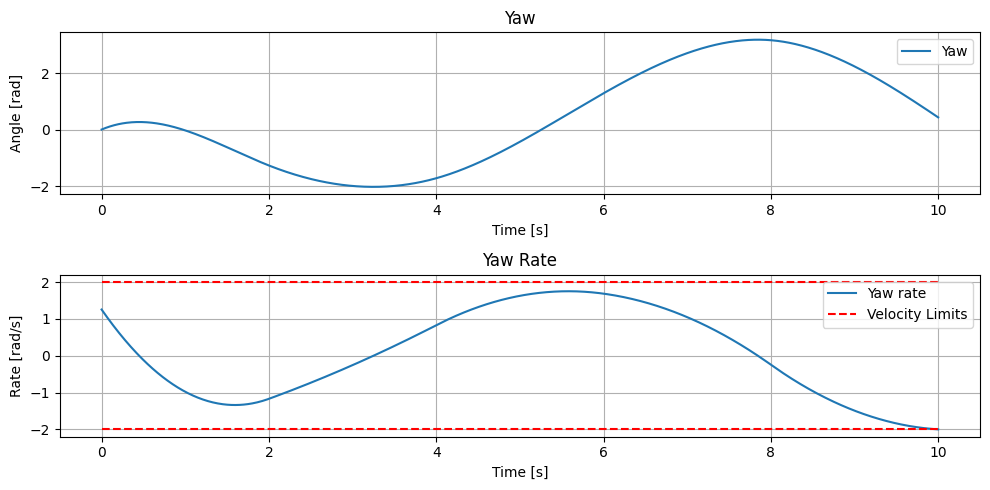